# **Inteligencia Artificial: Evaluación 4**

## **Hecho por:**
* David Daniel Henriquez Leal
* Santiago Andres Mercado Barandica

## Instalación de paquetes necesarios

In [ ]:
!pip install ucimlrepo
!sudo pip3 install keras

## Importación de librerías y datasets

In [ ]:
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import numpy as np
import kagglehub
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, mean_squared_error, r2_score
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.neural_network import MLPClassifier, MLPRegressor
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.svm import SVC
from time import time


path = kagglehub.dataset_download("hellbuoy/car-price-prediction") #Dataset para regresión lineal
datasetrlin_path = os.path.join(path, 'CarPrice_Assignment.csv')
datarlin = pd.read_csv(datasetrlin_path)

path = kagglehub.dataset_download("kandij/diabetes-dataset") #Dataset para regresión logística
datasetlog_path = os.path.join(path, 'diabetes2.csv')
datasetlog = pd.read_csv(datasetlog_path)

#Importar dataset de Abalone y digits
abalone = fetch_ucirepo(id=1)
digits = load_digits()

100%|██████████| 18.1k/18.1k [00:00<00:00, 22.3MB/s]

Extracting files...


100%|██████████| 8.92k/8.92k [00:00<00:00, 2.22MB/s]

Extracting files...


## **Taller 6**

### Descenso de gradiente

En este código, se implementa un modelo de regresión lineal que utiliza descenso del gradiente para ajustar los parámetros de predicción del precio de automóviles en función de características como la potencia y el tamaño del motor. Se elige una tasa de aprendizaje (`alpha`) de 0.01, que es lo suficientemente baja para asegurar que los ajustes a los parámetros no sean demasiado agresivos, evitando oscilaciones o divergencias durante el entrenamiento, y lo suficientemente alta para permitir una convergencia razonable en un número aceptable de iteraciones. Se establecen 3000 iteraciones para proporcionar al modelo suficiente tiempo para converger hacia una solución óptima, permitiendo una adecuada actualización de los parámetros en cada iteración y monitoreando la reducción del costo,.


Fold 1:
MSE: 14699990.02
R² Score: 0.7762

Fold 2:
MSE: 9211576.44
R² Score: 0.7891

Fold 3:
MSE: 14798009.71
R² Score: 0.8129

Resultados promedio de validación cruzada:
MSE promedio: 12903192.06 (±2610673.14)
R² Score promedio: 0.7927 (±0.0152)


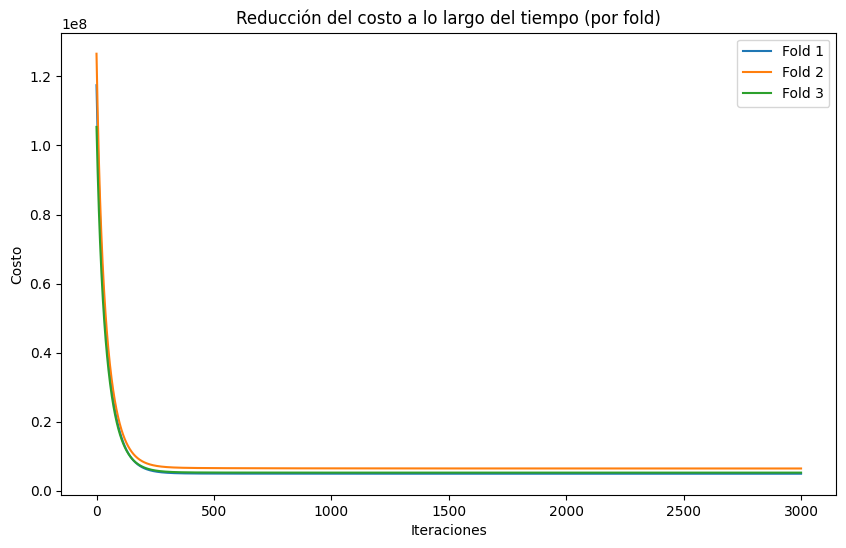


Parámetros del modelo final (entrenado con todos los datos):
Theta final: [13276.71057073  1960.14666723  1213.68456443  3489.5442126
  1168.79546267]


In [ ]:
# Fijar la semilla aleatoria global
np.random.seed(42)

# Seleccionar algunas características relevantes para la predicción de precios
X = datarlin[['horsepower', 'carwidth', 'enginesize', 'curbweight']].values
y = datarlin['price'].values

# Función de costo (MSE) y su gradiente para regresión lineal
def compute_cost(X, y, theta):
    m = len(y)
    predictions = X.dot(theta)
    cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
    return cost

def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        predictions = X.dot(theta)
        theta -= (alpha / m) * X.T.dot(predictions - y)
        cost_history[i] = compute_cost(X, y, theta)

    return theta, cost_history

def calculate_metrics(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return mse, r2

# Parámetros de configuración
alpha = 0.01
iterations = 3000

# Inicializar KFold para validación cruzada
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Variables para almacenar métricas de cada fold
fold_metrics = []
all_thetas = []
all_cost_histories = []

# Realizar validación cruzada
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f'\nFold {fold}:')

    # Dividir datos en entrenamiento y validación
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Normalizar características
    scaler = StandardScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)

    # Añadir columna de 1s para el bias
    X_train_normalized = np.hstack((np.ones((X_train_normalized.shape[0], 1)), X_train_normalized))
    X_val_normalized = np.hstack((np.ones((X_val_normalized.shape[0], 1)), X_val_normalized))

    # Inicializar theta
    theta = np.zeros(X_train_normalized.shape[1])

    # Entrenar modelo
    theta, cost_history = gradient_descent(X_train_normalized, y_train, theta, alpha, iterations)

    # Realizar predicciones
    predictions = X_val_normalized.dot(theta)

    # Calcular métricas
    mse, r2 = calculate_metrics(y_val, predictions)

    # Guardar resultados
    fold_metrics.append({'mse': mse, 'r2': r2})
    all_thetas.append(theta)
    all_cost_histories.append(cost_history)

    print(f'MSE: {mse:.2f}')
    print(f'R² Score: {r2:.4f}')

# Calcular promedios de las métricas
avg_mse = np.mean([m['mse'] for m in fold_metrics])
avg_r2 = np.mean([m['r2'] for m in fold_metrics])
std_mse = np.std([m['mse'] for m in fold_metrics])
std_r2 = np.std([m['r2'] for m in fold_metrics])

print('\nResultados promedio de validación cruzada:')
print(f'MSE promedio: {avg_mse:.2f} (±{std_mse:.2f})')
print(f'R² Score promedio: {avg_r2:.4f} (±{std_r2:.4f})')

# Graficar historiales de costo para cada fold
plt.figure(figsize=(10, 6))
for fold, cost_history in enumerate(all_cost_histories, 1):
    plt.plot(range(iterations), cost_history, label=f'Fold {fold}')
plt.xlabel('Iteraciones')
plt.ylabel('Costo')
plt.title('Reducción del costo a lo largo del tiempo (por fold)')
plt.legend()
plt.show()

# Entrenar modelo final con todos los datos
scaler_final = StandardScaler()
X_normalized = scaler_final.fit_transform(X)
X_normalized = np.hstack((np.ones((X_normalized.shape[0], 1)), X_normalized))
theta_final = np.zeros(X_normalized.shape[1])
theta_final, cost_history_final = gradient_descent(X_normalized, y, theta_final, alpha, iterations)

print('\nParámetros del modelo final (entrenado con todos los datos):')
print(f'Theta final: {theta_final}')

El modelo de regresión lineal ajustó bastante bien los datos, con un **R² de alrededor de 0.79**. El **MSE** en prueba fue cercano a **13 millones**, lo que refleja un error promedio aceptable para un problema de este tipo. El costo del entrenamiento también fue bajo, y el gráfico muestra cómo el error disminuye rápidamente al principio y luego se estabiliza, indicando que el descenso de gradiente está funcionando eficientemente para ajustar el modelo.

### Regresión Logística

Este código implementa un modelo de regresión logística para la clasificación de datos, utilizando validación cruzada de 3 particiones. Primero, se define la función sigmoide y las funciones necesarias para calcular el costo y realizar el descenso de gradiente, permitiendo que el modelo ajuste sus parámetros (theta) para minimizar el error de predicción. El conjunto de datos se normaliza y se agrega una columna de unos para el término de sesgo. Luego, con KFold, se aplica la validación cruzada dividiendo el conjunto de datos en tres subconjuntos, lo que garantiza que cada partición actúe como un conjunto de prueba y entrenamiento. El modelo se entrena y evalúa en cada partición, calculando los indicadores de desempeño: accuracy (precisión general), precision (precisión en las predicciones positivas) y recall (sensibilidad o tasa de verdaderos positivos). Finalmente, se calcula el promedio de estos valores para obtener una medida general del rendimiento del modelo.

In [ ]:
# Fijar la semilla aleatoria
np.random.seed(42)

# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Función de costo para regresión logística
def compute_cost_logistic(X, y, theta):
    m = len(y)
    predictions = sigmoid(X.dot(theta))
    cost = -(1 / m) * np.sum(y * np.log(predictions + 1e-10) + (1 - y) * np.log(1 - predictions + 1e-10))
    return cost

# Gradiente descendente para regresión logística
def gradient_descent_logistic(X, y, theta, alpha, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)

    for i in range(iterations):
        predictions = sigmoid(X.dot(theta))
        theta -= (alpha / m) * X.T.dot(predictions - y)
        cost_history[i] = compute_cost_logistic(X, y, theta)

    return theta, cost_history

# Declarar X y y
X = datasetlog.drop('Outcome', axis=1).values
y = datasetlog['Outcome'].values

# Normalizar características
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Agregar una columna de 1s para el bias (intercepto)
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Configuración para el gradiente descendente
alpha = 0.01
iterations = 3000

# Validación cruzada con 3 particiones
kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []

for train_index, test_index in kf.split(X):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Inicialización de los parámetros theta
    theta = np.zeros(X_train.shape[1])

    # Ejecutar descenso del gradiente
    theta, _ = gradient_descent_logistic(X_train, y_train, theta, alpha, iterations)

    # Evaluar el modelo en el conjunto de prueba
    predictions = sigmoid(X_test.dot(theta)) >= 0.5
    accuracies.append(accuracy_score(y_test, predictions))
    precisions.append(precision_score(y_test, predictions))
    recalls.append(recall_score(y_test, predictions))

# Calcular el promedio de los indicadores de desempeño
mean_accuracy = np.mean(accuracies)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print(f'Promedio de precisión (accuracy): {mean_accuracy:.4f}')
print(f'Promedio de precisión (precision): {mean_precision:.4f}')
print(f'Promedio de sensibilidad (recall): {mean_recall:.4f}')

Promedio de precisión (accuracy): 0.7578
Promedio de precisión (precision): 0.7014
Promedio de sensibilidad (recall): 0.5475


Los resultados muestran un promedio de precisión (accuracy) de 0.7578, lo que indica que el modelo clasifica correctamente el 75.78% de las observaciones en promedio. Sin embargo, la precisión (precision) de 0.7014 y la sensibilidad (recall) de 0.5475 sugieren que el modelo tiende a realizar más predicciones correctas para los casos positivos, pero no logra identificar todos los casos positivos correctamente. La precisión más alta que el recall indica que el modelo es relativamente bueno en predecir correctamente las clases positivas, pero su capacidad para detectar todos los casos verdaderos es limitada, lo cual podría ser un aspecto a mejorar si el objetivo es detectar con más sensibilidad los casos positivos.

## **Taller 7**

Este código implementa un modelo de perceptrón y una neurona artificial, aplicando validación cruzada con tres particiones para evaluar su desempeño en una tarea de clasificación binaria. Se define cada clase (Perceptron y SingleNeuron) con métodos para entrenar el modelo y realizar predicciones. Para evaluar ambos modelos, se utiliza la función cross_validate_model, que aplica la validación cruzada con KFold, entrenando y probando el modelo en diferentes subconjuntos de los datos. En cada iteración de validación cruzada, se calcula el accuracy, precision, y recall, y finalmente se obtiene el promedio de estas métricas para cada modelo, con la semilla aleatoria fijada para asegurar la repetibilidad.

In [ ]:
# Fijar la semilla aleatoria
np.random.seed(42)

# Declarar X y y
X = datasetlog.drop('Outcome', axis=1).values  # Características
y = datasetlog['Outcome'].values  # Variable objetivo

# Normalizar características
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Agregar una columna de 1s para el bias (intercepto)
X = np.hstack((np.ones((X.shape[0], 1)), X))

# Definir la clase del Perceptrón
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.n_iter):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights)
                y_predicted = self.activation_function(linear_output)
                update = self.learning_rate * (y[idx] - y_predicted)
                self.weights += update * x_i

    def activation_function(self, x):
        return np.where(x >= 0, 1, 0)

    def predict(self, X):
        linear_output = np.dot(X, self.weights)
        return self.activation_function(linear_output)

# Definir la clase de la Neurona Artificial
class SingleNeuron:
    def __init__(self, learning_rate=0.01, n_iter=1000):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.weights = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)

        for _ in range(self.n_iter):
            linear_output = np.dot(X, self.weights)
            y_predicted = self.sigmoid(linear_output)
            update = self.learning_rate * (y - y_predicted)
            self.weights += np.dot(X.T, update * y_predicted * (1 - y_predicted))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def predict(self, X):
        linear_output = np.dot(X, self.weights)
        return self.sigmoid(linear_output) >= 0.5  # Umbral de 0.5 para clasificación

# Función para realizar validación cruzada y calcular métricas promedio
def cross_validate_model(model_class, X, y, learning_rate=0.01, n_iter=1000, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies, precisions, recalls = [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Inicializar y entrenar el modelo
        model = model_class(learning_rate=learning_rate, n_iter=n_iter)
        model.fit(X_train, y_train)

        # Realizar predicciones y calcular métricas
        predictions = model.predict(X_test)
        accuracies.append(accuracy_score(y_test, predictions))
        precisions.append(precision_score(y_test, predictions))
        recalls.append(recall_score(y_test, predictions))

    # Calcular el promedio de las métricas
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)

    return mean_accuracy, mean_precision, mean_recall

# Ejecutar validación cruzada para el Perceptrón
perceptron_accuracy, perceptron_precision, perceptron_recall = cross_validate_model(
    Perceptron, X, y, learning_rate=0.01, n_iter=1000
)

# Ejecutar validación cruzada para la Neurona Artificial
neuron_accuracy, neuron_precision, neuron_recall = cross_validate_model(
    SingleNeuron, X, y, learning_rate=0.01, n_iter=1000
)

print(f'Promedio de precisión (accuracy) del Perceptrón: {perceptron_accuracy:.4f}')
print(f'Promedio de precisión (precision) del Perceptrón: {perceptron_precision:.4f}')
print(f'Promedio de sensibilidad (recall) del Perceptrón: {perceptron_recall:.4f}\n')

print(f'Promedio de precisión (accuracy) de la Neurona Artificial: {neuron_accuracy:.4f}')
print(f'Promedio de precisión (precision) de la Neurona Artificial: {neuron_precision:.4f}')
print(f'Promedio de sensibilidad (recall) de la Neurona Artificial: {neuron_recall:.4f}')


Promedio de precisión (accuracy) del Perceptrón: 0.7031
Promedio de precisión (precision) del Perceptrón: 0.5857
Promedio de sensibilidad (recall) del Perceptrón: 0.6101

Promedio de precisión (accuracy) de la Neurona Artificial: 0.7682
Promedio de precisión (precision) de la Neurona Artificial: 0.7095
Promedio de sensibilidad (recall) de la Neurona Artificial: 0.5787


Los resultados muestran que la neurona artificial tiene un mejor rendimiento general que el perceptrón. El promedio de precisión (accuracy) de la neurona artificial es 0.7682, en comparación con 0.7031 para el perceptrón, lo que indica que la neurona clasifica correctamente una mayor proporción de observaciones. En cuanto a la precisión (precision), el modelo de neurona también supera al perceptrón con un valor de 0.7095 frente a 0.5857, sugiriendo que la neurona tiene un mejor rendimiento al identificar correctamente los casos positivos. Sin embargo, en términos de sensibilidad (recall), ambos modelos son similares: el perceptrón obtiene 0.6101 y la neurona 0.5787, lo cual sugiere que, aunque la neurona es más precisa en las predicciones positivas, ambos modelos tienen una capacidad limitada para identificar todos los casos positivos. Estos resultados sugieren que la neurona artificial podría ser una mejor opción para tareas donde la precisión es prioritaria, mientras que el perceptrón podría usarse en escenarios donde la sensibilidad sea más importante.

## **Taller 8**

## Para el dataset Digits

### RNA de una capa

Este código implementa un modelo de red neuronal multicapa (MLP) para el reconocimiento de dígitos utilizando el dataset digits de sklearn. Tras dividir los datos en conjuntos de entrenamiento y prueba, se escalan y se entrena una red neuronal con diferentes configuraciones, ajustando primero el número de neuronas en la capa oculta para alcanzar un umbral de precisión en el conjunto de prueba del 90%. Una vez identificada la cantidad mínima de neuronas necesarias para cumplir este objetivo, se prueban distintas funciones de activación (ReLU, tanh y logistic) para evaluar cuál produce mejores resultados. Finalmente, se grafican las precisiones de entrenamiento y prueba para analizar el impacto de cada configuración, y se imprimen las conclusiones sobre el número óptimo de neuronas y la función de activación más adecuada.


Buscando el mínimo número de neuronas necesario...
Umbral de precisión aceptable: 90.0%

Resultados por número de neuronas:
--------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neuronas:  2 | Test Accuracy: 0.5407 ± 0.0129 | Train Accuracy: 0.6103 ± 0.0077


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neuronas:  3 | Test Accuracy: 0.7857 ± 0.0182 | Train Accuracy: 0.8577 ± 0.0184


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Neuronas:  4 | Test Accuracy: 0.8761 ± 0.0060 | Train Accuracy: 0.9656 ± 0.0067
Neuronas:  5 | Test Accuracy: 0.9151 ± 0.0035 | Train Accuracy: 0.9941 ± 0.0013
Neuronas:  6 | Test Accuracy: 0.9068 ± 0.0060 | Train Accuracy: 0.9927 ± 0.0017
Neuronas:  8 | Test Accuracy: 0.9360 ± 0.0097 | Train Accuracy: 0.9972 ± 0.0005
Neuronas: 10 | Test Accuracy: 0.9534 ± 0.0020 | Train Accuracy: 0.9993 ± 0.0005
Neuronas: 12 | Test Accuracy: 0.9541 ± 0.0045 | Train Accuracy: 0.9997 ± 0.0005
Neuronas: 15 | Test Accuracy: 0.9541 ± 0.0061 | Train Accuracy: 0.9997 ± 0.0005
Neuronas: 20 | Test Accuracy: 0.9582 ± 0.0017 | Train Accuracy: 1.0000 ± 0.0000
Neuronas: 25 | Test Accuracy: 0.9673 ± 0.0010 | Train Accuracy: 1.0000 ± 0.0000
Neuronas: 30 | Test Accuracy: 0.9715 ± 0.0020 | Train Accuracy: 1.0000 ± 0.0000


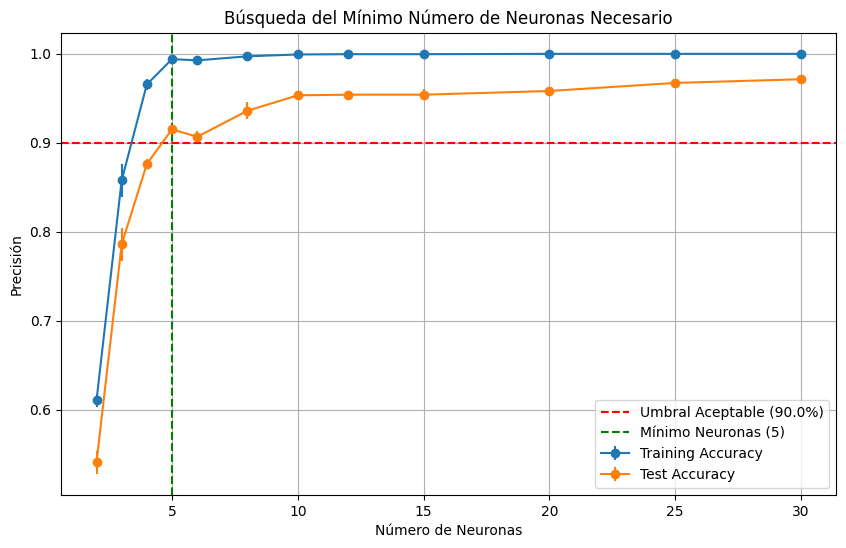


Comparación de funciones de activación con el mínimo número de neuronas:
--------------------------------------------------------------------
Activación: relu     | Test Accuracy: 0.9151 ± 0.0035 | Train Accuracy: 0.9941 ± 0.0013


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Activación: tanh     | Test Accuracy: 0.9158 ± 0.0043 | Train Accuracy: 0.9930 ± 0.0021


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Activación: logistic | Test Accuracy: 0.8956 ± 0.0017 | Train Accuracy: 0.9704 ± 0.0034


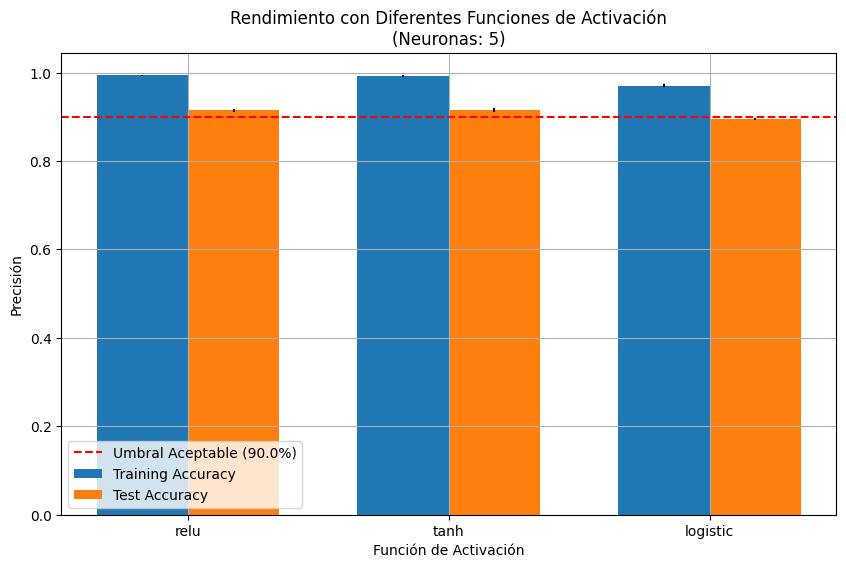


Conclusiones:
-------------
- El mínimo número de neuronas necesario para alcanzar 90.0% de precisión es: 5
- Con 5 neuronas:
  * Precisión en entrenamiento: 0.9941 ± 0.0013
  * Precisión en prueba: 0.9151 ± 0.0035
- La mejor función de activación con 5 neuronas es: tanh
  * Precisión en entrenamiento: 0.9930 ± 0.0021
  * Precisión en prueba: 0.9158 ± 0.0043


In [ ]:
# Fijar semilla para reproducibilidad
np.random.seed(42)

# Cargar el dataset
digits = load_digits()
X, y = digits.data, digits.target

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir un umbral de precisión aceptable (90%)
ACCEPTABLE_ACCURACY = 0.90

def evaluate_neural_network(hidden_neurons, X, y, activation='relu', max_iter=1000):
    """
    Evalúa una red neuronal con validación cruzada.
    """
    # Configurar K-Fold
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    train_accuracies = []
    test_accuracies = []
    models = []

    # Para cada fold
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # Dividir datos
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        # Escalar datos
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler.transform(X_fold_val)

        # Crear y entrenar modelo
        mlp = MLPClassifier(
            hidden_layer_sizes=(hidden_neurons,),
            activation=activation,
            max_iter=max_iter,
            random_state=42
        )

        mlp.fit(X_fold_train_scaled, y_fold_train)

        # Calcular precisión
        train_acc = accuracy_score(y_fold_train, mlp.predict(X_fold_train_scaled))
        test_acc = accuracy_score(y_fold_val, mlp.predict(X_fold_val_scaled))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        models.append(mlp)

    # Calcular promedios y desviaciones estándar
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    std_train_accuracy = np.std(train_accuracies)
    std_test_accuracy = np.std(test_accuracies)

    # Retornar el mejor modelo basado en precisión de validación
    best_model_idx = np.argmax(test_accuracies)
    best_model = models[best_model_idx]

    return avg_train_accuracy, std_train_accuracy, avg_test_accuracy, std_test_accuracy, best_model

# 1. Búsqueda del mínimo número de neuronas
neuron_numbers = [2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 25, 30]
train_scores_neurons = []
train_stds_neurons = []
test_scores_neurons = []
test_stds_neurons = []
found_minimum = False
min_neurons = None

print("\nBuscando el mínimo número de neuronas necesario...")
print(f"Umbral de precisión aceptable: {ACCEPTABLE_ACCURACY*100}%")
print("\nResultados por número de neuronas:")
print("--------------------------------")

for neurons in neuron_numbers:
    train_acc, train_std, test_acc, test_std, _ = evaluate_neural_network(neurons, X_train, y_train)
    train_scores_neurons.append(train_acc)
    train_stds_neurons.append(train_std)
    test_scores_neurons.append(test_acc)
    test_stds_neurons.append(test_std)

    print(f"Neuronas: {neurons:2d} | Test Accuracy: {test_acc:.4f} ± {test_std:.4f} | Train Accuracy: {train_acc:.4f} ± {train_std:.4f}")

    # Verificar si hemos alcanzado el umbral aceptable
    if test_acc >= ACCEPTABLE_ACCURACY and not found_minimum:
        min_neurons = neurons
        found_minimum = True

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.errorbar(neuron_numbers, train_scores_neurons, yerr=train_stds_neurons, fmt='o-', label='Training Accuracy')
plt.errorbar(neuron_numbers, test_scores_neurons, yerr=test_stds_neurons, fmt='o-', label='Test Accuracy')
plt.axhline(y=ACCEPTABLE_ACCURACY, color='r', linestyle='--', label=f'Umbral Aceptable ({ACCEPTABLE_ACCURACY*100}%)')
if min_neurons:
    plt.axvline(x=min_neurons, color='g', linestyle='--', label=f'Mínimo Neuronas ({min_neurons})')
plt.xlabel('Número de Neuronas')
plt.ylabel('Precisión')
plt.title('Búsqueda del Mínimo Número de Neuronas Necesario')
plt.legend()
plt.grid(True)
plt.show()

# 2. Comparar diferentes funciones de activación con el mínimo número de neuronas
if min_neurons:
    activations = ['relu', 'tanh', 'logistic']
    train_scores_act = []
    train_stds_act = []
    test_scores_act = []
    test_stds_act = []

    print("\nComparación de funciones de activación con el mínimo número de neuronas:")
    print("--------------------------------------------------------------------")

    for activation in activations:
        train_acc, train_std, test_acc, test_std, _ = evaluate_neural_network(
            min_neurons, X_train, y_train, activation=activation
        )
        train_scores_act.append(train_acc)
        train_stds_act.append(train_std)
        test_scores_act.append(test_acc)
        test_stds_act.append(test_std)
        print(f"Activación: {activation:8} | Test Accuracy: {test_acc:.4f} ± {test_std:.4f} | Train Accuracy: {train_acc:.4f} ± {train_std:.4f}")

    # Visualizar resultados de las funciones de activación
    plt.figure(figsize=(10, 6))
    x = np.arange(len(activations))
    width = 0.35

    plt.bar(x - width/2, train_scores_act, width, yerr=train_stds_act, label='Training Accuracy')
    plt.bar(x + width/2, test_scores_act, width, yerr=test_stds_act, label='Test Accuracy')
    plt.axhline(y=ACCEPTABLE_ACCURACY, color='r', linestyle='--', label=f'Umbral Aceptable ({ACCEPTABLE_ACCURACY*100}%)')
    plt.xticks(x, activations)
    plt.xlabel('Función de Activación')
    plt.ylabel('Precisión')
    plt.title(f'Rendimiento con Diferentes Funciones de Activación\n(Neuronas: {min_neurons})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Imprimir conclusiones
print("\nConclusiones:")
print("-------------")
if min_neurons:
    print(f"- El mínimo número de neuronas necesario para alcanzar {ACCEPTABLE_ACCURACY*100}% de precisión es: {min_neurons}")
    print(f"- Con {min_neurons} neuronas:")
    idx = neuron_numbers.index(min_neurons)
    print(f"  * Precisión en entrenamiento: {train_scores_neurons[idx]:.4f} ± {train_stds_neurons[idx]:.4f}")
    print(f"  * Precisión en prueba: {test_scores_neurons[idx]:.4f} ± {test_stds_neurons[idx]:.4f}")

    # Encontrar la mejor función de activación
    best_activation_idx = np.argmax(test_scores_act)
    best_activation = activations[best_activation_idx]
    print(f"- La mejor función de activación con {min_neurons} neuronas es: {best_activation}")
    print(f"  * Precisión en entrenamiento: {train_scores_act[best_activation_idx]:.4f} ± {train_stds_act[best_activation_idx]:.4f}")
    print(f"  * Precisión en prueba: {test_scores_act[best_activation_idx]:.4f} ± {test_stds_act[best_activation_idx]:.4f}")
else:
    print(f"No se encontró una configuración que alcance el umbral de {ACCEPTABLE_ACCURACY*100}% de precisión.")

Se puede observar cómo al incrementar el número de neuronas en la red neuronal, la precisión en el conjunto de prueba mejora significativamente al principio, pero después de cierto punto (alrededor de 5-6 neuronas), las mejoras son marginales. El umbral de precisión aceptable del 90% se alcanza con 5 neuronas, que es el número mínimo necesario. A partir de ahí, la precisión se estabiliza en torno al 95% con unas 10 neuronas, y no parece haber un gran beneficio en añadir más neuronas. De hecho, un exceso de neuronas podría llevar a sobreajuste, como se puede ver en la pequeña diferencia entre las curvas de precisión de entrenamiento (que sigue aumentando) y de prueba (que se estabiliza), lo que indica que el modelo podría estarse especializando demasiado en los datos de entrenamiento.

En cuanto a las funciones de activación, se observó que no hubo una diferencia muy significativa en el rendimiento al cambiar entre "tanh" y "relu", ambas alcanzaron resultados similares. Sin embargo, la función "logistic" resultó en una ligera disminución de la precisión en comparación con las otras dos. A pesar de estas variaciones, ninguna función de activación redujo la precisión por debajo del umbral aceptable, lo que indica que la red neuronal puede ser robusta independientemente de la función activación elegida, aunque "tanh" fue la que mostró el mejor desempeño en este caso.

### Implementación en TensorFlow

Este código utiliza un modelo de red neuronal para clasificar imágenes de dígitos escritos a mano, aprovechando validación cruzada para evaluar su desempeño. Primero, carga el conjunto de datos de dígitos (load_digits), seguido de la normalización de las características para mejorar el rendimiento. Luego, configura la validación cruzada con KFold (tres divisiones) para entrenar el modelo en distintas particiones, manteniendo la repetibilidad del proceso al fijar una semilla aleatoria. En cada iteración, el modelo se entrena utilizando una capa oculta con cinco neuronas y una capa de salida con diez neuronas (una para cada dígito de 0 a 9), aplicando una función de activación softmax en la salida. Tras el entrenamiento, el modelo predice los dígitos de las imágenes en el conjunto de prueba actual y calcula las métricas de accuracy, precision y recall, las cuales se almacenan para promediar al final. En la última iteración, además, se visualizan los pesos de la capa oculta y se muestran métricas detalladas del entrenamiento. Al finalizar el proceso, se imprimen los valores promedio de las métricas y se presentan gráficas de precisión y pérdida que ilustran el rendimiento del modelo en la última iteración.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Pesos de la capa oculta (última iteración):
----------------------
Forma de la matriz de pesos: (64, 5)
Número de parámetros en la capa oculta: 325

Métricas detalladas (última iteración):
-------------------
Pérdida final en entrenamiento: 0.2306
Pérdida final en validación: 0.6636
Precisión final en entrenamiento: 0.9582
Precisión final en validación: 0.7917

Resultados Promedio de Validación Cruzada:
------------------------------------------
Precisión Promedio: 0.8787
Precisión (macro) Promedio: 0.8812
Recall (macro) Promedio: 0.8796


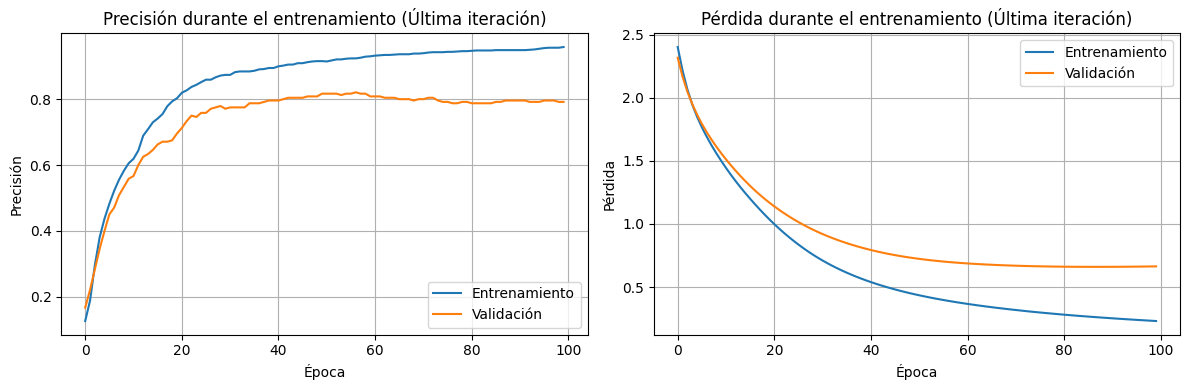

In [ ]:
# Cargar los datos
digits = load_digits()

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

X, y = digits.data, digits.target

# Normalizar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Configuración de validación cruzada
kf = KFold(n_splits=3, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Convertir las etiquetas a formato one-hot
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)

    # Construir el modelo
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64,)),  # Capa de entrada: 64 características (8x8 pixels)
        tf.keras.layers.Dense(5, activation='tanh'),  # Capa oculta: 5 neuronas con ReLU
        tf.keras.layers.Dense(10, activation='softmax')  # Capa de salida: 10 clases (dígitos 0-9)
    ])

    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entrenar el modelo
    history = model.fit(
        X_train, y_train_encoded,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        verbose=0
    )

    # Evaluar el modelo en el conjunto de prueba actual
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calcular métricas y almacenar resultados
    accuracy_scores.append(accuracy_score(y_test, y_pred_classes))
    precision_scores.append(precision_score(y_test, y_pred_classes, average='macro', zero_division=1))
    recall_scores.append(recall_score(y_test, y_pred_classes, average='macro', zero_division=1))

    # Si es la última iteración, mostrar los pesos y métricas adicionales
    if fold == 3:
        # Mostrar los pesos de la capa oculta
        weights, biases = model.layers[0].get_weights()
        print("\nPesos de la capa oculta (última iteración):")
        print("----------------------")
        print(f"Forma de la matriz de pesos: {weights.shape}")
        print(f"Número de parámetros en la capa oculta: {weights.size + biases.size}")

        # Calcular y mostrar algunas métricas adicionales
        print("\nMétricas detalladas (última iteración):")
        print("-------------------")
        print(f"Pérdida final en entrenamiento: {history.history['loss'][-1]:.4f}")
        print(f"Pérdida final en validación: {history.history['val_loss'][-1]:.4f}")
        print(f"Precisión final en entrenamiento: {history.history['accuracy'][-1]:.4f}")
        print(f"Precisión final en validación: {history.history['val_accuracy'][-1]:.4f}")

# Calcular el promedio de las métricas de validación cruzada
average_accuracy = np.mean(accuracy_scores)
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)

print("\nResultados Promedio de Validación Cruzada:")
print("------------------------------------------")
print(f"Precisión Promedio: {average_accuracy:.4f}")
print(f"Precisión (macro) Promedio: {average_precision:.4f}")
print(f"Recall (macro) Promedio: {average_recall:.4f}")

# Gráfica del entrenamiento en la última iteración
plt.figure(figsize=(12, 4))

# Gráfica de precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión durante el entrenamiento (Última iteración)')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Gráfica de pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida durante el entrenamiento (Última iteración)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


El modelo alcanzó una alta precisión en el conjunto de entrenamiento, estabilizándose alrededor del 95.82%, mientras que en el conjunto de validación alcanzó aproximadamente el 79.17%. La curva de pérdida evidencia que, aunque el modelo continúa mejorando en el conjunto de entrenamiento, la pérdida en el conjunto de validación se estabiliza en un valor mayor, lo que sugiere la posible presencia de sobreajuste. A pesar de esto, los promedios de precisión (0.8787), precisión macro (0.8812), y recall macro (0.8796) en la validación cruzada indican un rendimiento consistente. Estos resultados reflejan que el modelo es efectivo para clasificar dígitos, pero podría beneficiarse de técnicas adicionales de regularización para mejorar su generalización.

### RNA multicapa

Este código implementa una red neuronal multicapa para clasificar dígitos del conjunto de datos `digits` de Scikit-Learn, utilizando varias configuraciones de capas ocultas y activaciones. Primero, los datos se escalan para mejorar la precisión del modelo y luego se dividen en conjunto de entrenamiento y prueba. Después, se definen y evalúan diferentes arquitecturas de redes neuronales (variando el número de capas y neuronas) con el objetivo de encontrar aquella que logre la mejor precisión en el conjunto de prueba. Se visualizan los resultados en gráficas para comparar el rendimiento de cada configuración, destacando la arquitectura más precisa mediante una matriz de confusión y una curva de pérdida. Finalmente, el código analiza el rendimiento promedio de cada configuración según su número de capas, la eficiencia en términos de precisión por neurona, y revisa posibles indicios de sobreajuste en cada arquitectura.


Evaluación de diferentes arquitecturas multicapa:
---------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Arquitectura: (5, 5)
Capas ocultas: 2
Total neuronas: 10
Precisión entrenamiento: 0.9927 ± 0.0026
Precisión validación: 0.8608 ± 0.0097

Arquitectura: (10, 5)
Capas ocultas: 2
Total neuronas: 15
Precisión entrenamiento: 0.9969 ± 0.0009
Precisión validación: 0.9005 ± 0.0108


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Arquitectura: (5, 10)
Capas ocultas: 2
Total neuronas: 15
Precisión entrenamiento: 0.9969 ± 0.0009
Precisión validación: 0.8706 ± 0.0207

Arquitectura: (10, 10)
Capas ocultas: 2
Total neuronas: 20
Precisión entrenamiento: 0.9997 ± 0.0005
Precisión validación: 0.9436 ± 0.0074


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Arquitectura: (5, 5, 5)
Capas ocultas: 3
Total neuronas: 15
Precisión entrenamiento: 0.9903 ± 0.0055
Precisión validación: 0.8330 ± 0.0148

Arquitectura: (10, 7, 5)
Capas ocultas: 3
Total neuronas: 22
Precisión entrenamiento: 0.9955 ± 0.0027
Precisión validación: 0.8615 ± 0.0052


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Arquitectura: (5, 7, 5)
Capas ocultas: 3
Total neuronas: 17
Precisión entrenamiento: 0.9927 ± 0.0026
Precisión validación: 0.8629 ± 0.0010

Arquitectura: (10, 10, 10)
Capas ocultas: 3
Total neuronas: 30
Precisión entrenamiento: 0.9986 ± 0.0005
Precisión validación: 0.9248 ± 0.0045

Arquitectura: (8, 8, 8)
Capas ocultas: 3
Total neuronas: 24
Precisión entrenamiento: 0.9990 ± 0.0009
Precisión validación: 0.9068 ± 0.0060

Arquitectura: (10, 8, 6)
Capas ocultas: 3
Total neuronas: 24
Precisión entrenamiento: 0.9993 ± 0.0005
Precisión validación: 0.9116 ± 0.0087


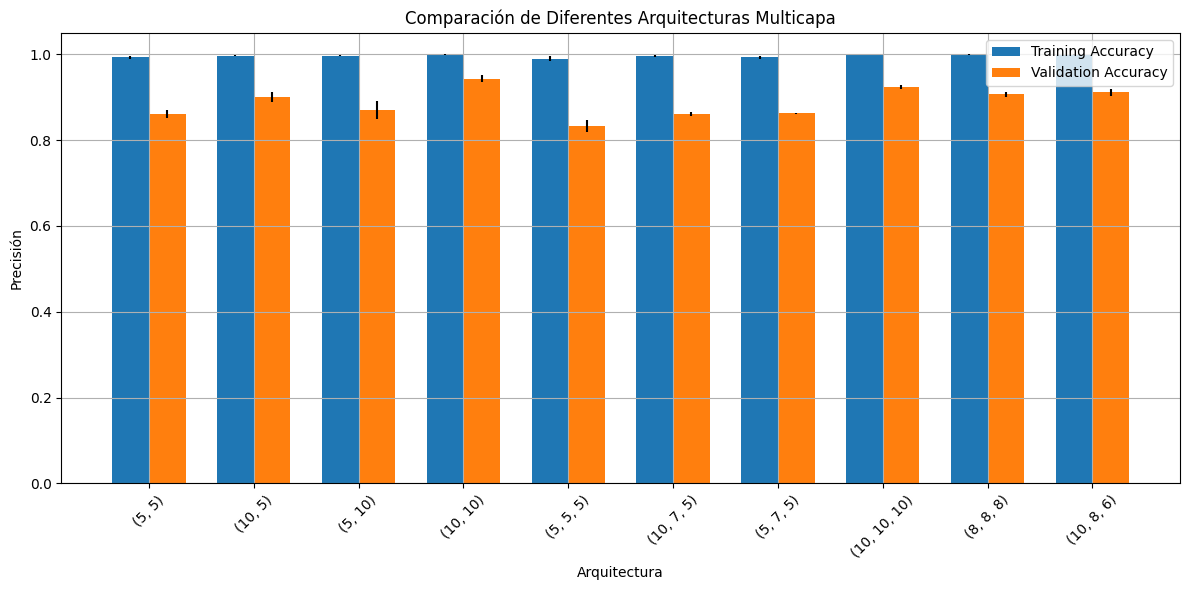


Mejor arquitectura encontrada:
----------------------------
Configuración: (10, 10)
Número de capas ocultas: 2
Total de neuronas: 20
Precisión en entrenamiento: 0.9997 ± 0.0005
Precisión en validación: 0.9436 ± 0.0074


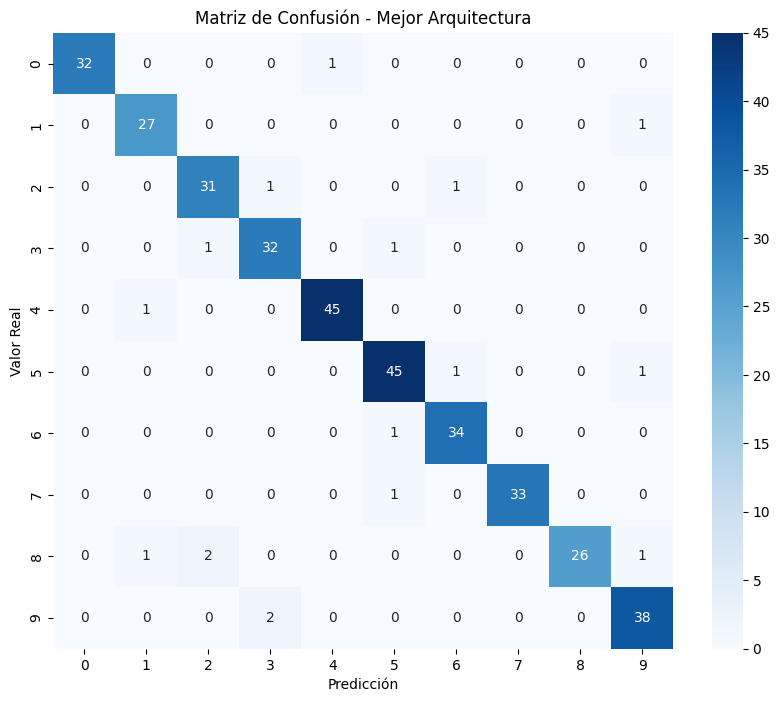

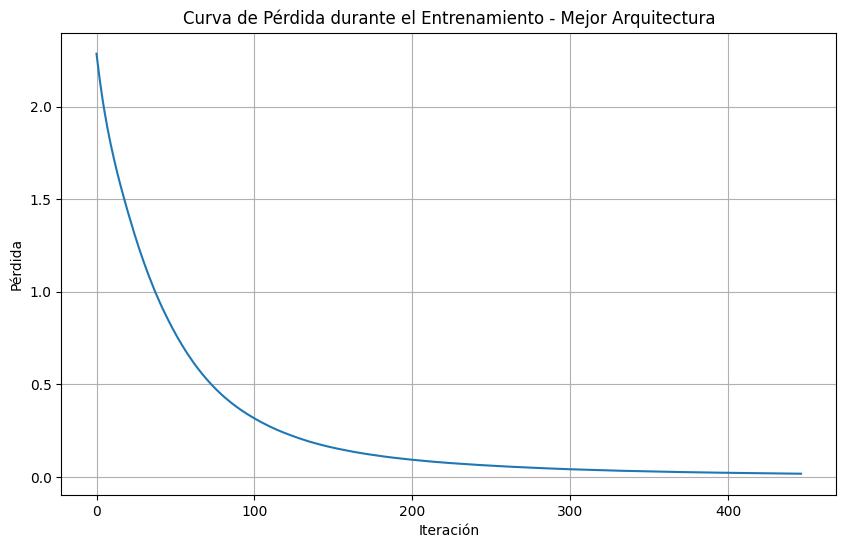


Rendimiento promedio por número de capas:
--------------------------------------
2 capas: 0.8939 ± 0.0322
3 capas: 0.8834 ± 0.0329

Análisis de sobreajuste:
----------------------

Arquitectura (5, 5):
  Diferencia entre entrenamiento y validación: 0.1319
  ⚠️ Posible sobreajuste
  - Train: 0.9927 ± 0.0026
  - Val:   0.8608 ± 0.0097

Arquitectura (10, 5):
  Diferencia entre entrenamiento y validación: 0.0964
  ⚠️ Posible sobreajuste
  - Train: 0.9969 ± 0.0009
  - Val:   0.9005 ± 0.0108

Arquitectura (5, 10):
  Diferencia entre entrenamiento y validación: 0.1263
  ⚠️ Posible sobreajuste
  - Train: 0.9969 ± 0.0009
  - Val:   0.8706 ± 0.0207

Arquitectura (10, 10):
  Diferencia entre entrenamiento y validación: 0.0560
  ⚠️ Posible sobreajuste
  - Train: 0.9997 ± 0.0005
  - Val:   0.9436 ± 0.0074

Arquitectura (5, 5, 5):
  Diferencia entre entrenamiento y validación: 0.1573
  ⚠️ Posible sobreajuste
  - Train: 0.9903 ± 0.0055
  - Val:   0.8330 ± 0.0148

Arquitectura (10, 7, 5):
  Diferenci

In [ ]:
# Fijar semilla para reproducibilidad
np.random.seed(42)

# Cargar datos
digits = load_digits()
X, y = digits.data, digits.target

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_neural_network(hidden_layers, X, y, activation='relu', max_iter=1000):
    """
    Evalúa una red neuronal con validación cruzada.
    """
    # Configurar K-Fold
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    train_accuracies = []
    test_accuracies = []
    models = []

    # Para cada fold
    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        # Dividir datos
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]

        # Escalar datos
        scaler = StandardScaler()
        X_fold_train_scaled = scaler.fit_transform(X_fold_train)
        X_fold_val_scaled = scaler.transform(X_fold_val)

        # Crear y entrenar modelo
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layers,
            activation='tanh',
            max_iter=max_iter,
            random_state=42
        )

        mlp.fit(X_fold_train_scaled, y_fold_train)

        # Calcular precisión
        train_acc = accuracy_score(y_fold_train, mlp.predict(X_fold_train_scaled))
        test_acc = accuracy_score(y_fold_val, mlp.predict(X_fold_val_scaled))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        models.append(mlp)

    # Calcular promedios
    avg_train_accuracy = np.mean(train_accuracies)
    avg_test_accuracy = np.mean(test_accuracies)
    std_train_accuracy = np.std(train_accuracies)
    std_test_accuracy = np.std(test_accuracies)

    # Retornar el mejor modelo basado en precisión de validación
    best_model_idx = np.argmax(test_accuracies)
    best_model = models[best_model_idx]

    return (avg_train_accuracy, std_train_accuracy,
            avg_test_accuracy, std_test_accuracy,
            best_model)

# Definir diferentes arquitecturas multicapa para probar
architectures = [
    (5, 5),         # Dos capas con 5 neuronas cada una
    (10, 5),        # Dos capas con 10 y 5 neuronas
    (5, 10),        # Dos capas con 5 y 10 neuronas
    (10, 10),       # Dos capas con 10 neuronas cada una
    (5, 5, 5),      # Tres capas con 5 neuronas cada una
    (10, 7, 5),     # Tres capas con tamaño decreciente
    (5, 7, 5),      # Tres capas con forma de diamante
    (10, 10, 10),   # Tres capas con 10 neuronas cada una
    (8, 8, 8),      # Tres capas con 8 neuronas cada una
    (10, 8, 6)      # Tres capas decrecientes graduales
]

# Evaluar cada arquitectura
results = []
print("\nEvaluación de diferentes arquitecturas multicapa:")
print("---------------------------------------------")

for arch in architectures:
    train_acc, train_std, test_acc, test_std, model = evaluate_neural_network(arch, X_train, y_train)
    results.append({
        'architecture': arch,
        'train_accuracy': train_acc,
        'train_std': train_std,
        'test_accuracy': test_acc,
        'test_std': test_std,
        'n_layers': len(arch),
        'total_neurons': sum(arch),
        'model': model
    })

    print(f"\nArquitectura: {arch}")
    print(f"Capas ocultas: {len(arch)}")
    print(f"Total neuronas: {sum(arch)}")
    print(f"Precisión entrenamiento: {train_acc:.4f} ± {train_std:.4f}")
    print(f"Precisión validación: {test_acc:.4f} ± {test_std:.4f}")

# Visualizar resultados
plt.figure(figsize=(12, 6))
architectures_labels = [str(arch) for arch in architectures]
train_scores = [r['train_accuracy'] for r in results]
test_scores = [r['test_accuracy'] for r in results]
train_errors = [r['train_std'] for r in results]
test_errors = [r['test_std'] for r in results]

x = np.arange(len(architectures))
width = 0.35

plt.bar(x - width/2, train_scores, width, yerr=train_errors, label='Training Accuracy')
plt.bar(x + width/2, test_scores, width, yerr=test_errors, label='Validation Accuracy')
plt.xlabel('Arquitectura')
plt.ylabel('Precisión')
plt.title('Comparación de Diferentes Arquitecturas Multicapa')
plt.xticks(x, architectures_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Encontrar la mejor arquitectura
best_result = max(results, key=lambda x: x['test_accuracy'])
print("\nMejor arquitectura encontrada:")
print("----------------------------")
print(f"Configuración: {best_result['architecture']}")
print(f"Número de capas ocultas: {best_result['n_layers']}")
print(f"Total de neuronas: {best_result['total_neurons']}")
print(f"Precisión en entrenamiento: {best_result['train_accuracy']:.4f} ± {best_result['train_std']:.4f}")
print(f"Precisión en validación: {best_result['test_accuracy']:.4f} ± {best_result['test_std']:.4f}")

# Matriz de confusión para la mejor arquitectura
best_model = best_result['model']
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Mejor Arquitectura')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Visualizar la curva de aprendizaje de la mejor arquitectura
plt.figure(figsize=(10, 6))
plt.plot(best_model.loss_curve_)
plt.title('Curva de Pérdida durante el Entrenamiento - Mejor Arquitectura')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.grid(True)
plt.show()

# Análisis por número de capas
results_by_layers = {}
for r in results:
    n_layers = r['n_layers']
    if n_layers not in results_by_layers:
        results_by_layers[n_layers] = []
    results_by_layers[n_layers].append(r['test_accuracy'])

print("\nRendimiento promedio por número de capas:")
print("--------------------------------------")
for n_layers, accuracies in results_by_layers.items():
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"{n_layers} capas: {avg_acc:.4f} ± {std_acc:.4f}")

# Análisis de sobreajuste
print("\nAnálisis de sobreajuste:")
print("----------------------")
for result in results:
    arch = result['architecture']
    train_acc = result['train_accuracy']
    test_acc = result['test_accuracy']
    diff = train_acc - test_acc
    print(f"\nArquitectura {arch}:")
    print(f"  Diferencia entre entrenamiento y validación: {diff:.4f}")
    if diff > 0.05:
        print("  ⚠️ Posible sobreajuste")
        print(f"  - Train: {train_acc:.4f} ± {result['train_std']:.4f}")
        print(f"  - Val:   {test_acc:.4f} ± {result['test_std']:.4f}")
    else:
        print("  ✓ Sin indicios de sobreajuste")
        print(f"  - Train: {train_acc:.4f} ± {result['train_std']:.4f}")
        print(f"  - Val:   {test_acc:.4f} ± {result['test_std']:.4f}")

# Análisis de eficiencia
print("\nAnálisis de eficiencia (precisión por neurona):")
print("--------------------------------------------")
for result in results:
    arch = result['architecture']
    efficiency = result['test_accuracy'] / result['total_neurons']
    print(f"Arquitectura {arch}: {efficiency:.5f} precisión/neurona")

Se observa que la precisión en los datos de prueba se mantiene en un rango cercano, oscilando entre valores similares, lo cual indica una consistencia entre los modelos evaluados. La arquitectura que alcanza la mayor precisión en prueba es la de dos capas ocultas con configuración `(10, 10)`, con una precisión cercana al valor óptimo de los modelos evaluados. Esta configuración logra un balance entre el número de neuronas y capas, lo que permite una alta precisión sin incurrir en sobreajuste evidente. Además, al tener un tamaño pequeño, la arquitectura `(10, 10)` es computacionalmente más eficiente que otras configuraciones más grandes, mientras sigue logrando un rendimiento superior en términos de precisión. Por estas razones, se considera que la configuración `(10, 10)` es la mejor para el conjunto de datos, ya que mantiene la simplicidad y optimiza el rendimiento sin comprometer la generalización del modelo.

### Implementación en TensorFlow

Este código implementa y compara el rendimiento de dos modelos de redes neuronales en el reconocimiento de dígitos: uno sin dropout y otro con un 30% de dropout, usando el conjunto de datos de dígitos de `sklearn`. Primero, normaliza los datos, los divide en entrenamiento y prueba, y define una función para crear un modelo con dos capas ocultas `Dense` de 10 neuronas cada una, usando activación `tanh` y una capa de salida con activación `softmax` para clasificación. Ambos modelos se entrenan y luego se grafica la pérdida y precisión en entrenamiento y validación. Finalmente, se evalúan ambos modelos en el conjunto de prueba, mostrando su precisión y pérdida; además, se genera una matriz de confusión para el modelo con dropout para visualizar las predicciones.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Resultados de validación cruzada con 3 conjuntos:
Precisión promedio: 0.9516
Precisión (macro) promedio: 0.9513
Recall (macro) promedio: 0.9522


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Evaluación final del modelo con Dropout:
Precisión en el conjunto de prueba: 0.9667
Pérdida en el conjunto de prueba: 0.1373
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


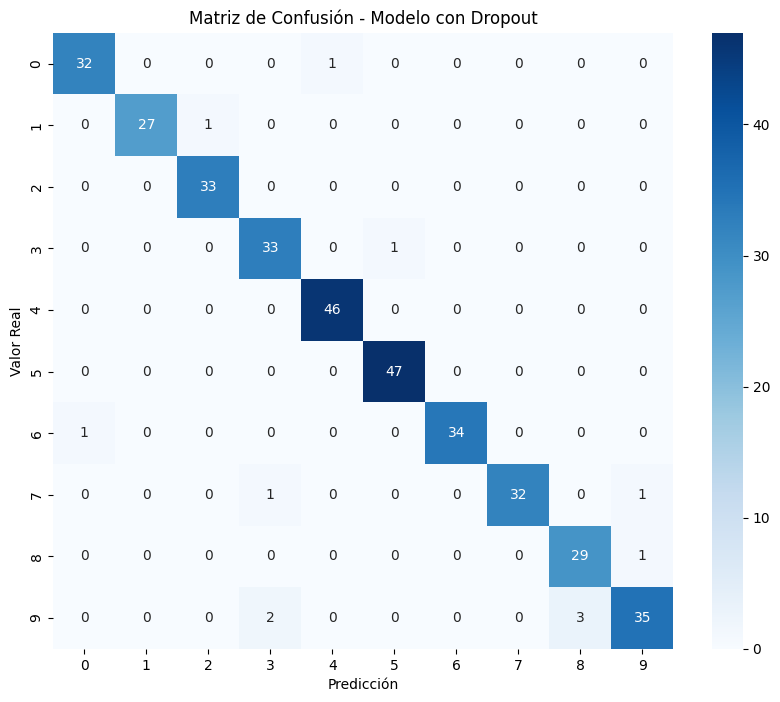

In [ ]:
# Configuración inicial
digits = load_digits()
X, y = digits.data, digits.target

# Configurar semilla para reproducibilidad
np.random.seed(42)
tf.random.set_seed(42)

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Definir función para crear el modelo
def create_model(dropout_rate=0.0):
    model = Sequential([
        Dense(10, activation='tanh', input_shape=(64,)),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Configuración de KFold y métricas
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
accuracy_scores, precision_scores, recall_scores = [], [], []

# Entrenamiento con validación cruzada
for train_index, val_index in kfold.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Crear y entrenar el modelo
    model = create_model(dropout_rate=0.3)
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

    # Predicciones y cálculo de métricas
    y_pred = np.argmax(model.predict(X_val), axis=1)
    accuracy_scores.append(accuracy_score(y_val, y_pred))
    precision_scores.append(precision_score(y_val, y_pred, average='macro', zero_division=0))
    recall_scores.append(recall_score(y_val, y_pred, average='macro', zero_division=0))

# Resultados promedio
print("Resultados de validación cruzada con 3 conjuntos:")
print(f"Precisión promedio: {np.mean(accuracy_scores):.4f}")
print(f"Precisión (macro) promedio: {np.mean(precision_scores):.4f}")
print(f"Recall (macro) promedio: {np.mean(recall_scores):.4f}")

# Evaluación final en el conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
final_model = create_model(dropout_rate=0.3)
final_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print("\nEvaluación final del modelo con Dropout:")
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Matriz de confusión en el conjunto de prueba
y_pred_test = np.argmax(final_model.predict(X_test), axis=1)
plt.figure(figsize=(10, 8))
conf_matrix = tf.math.confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Modelo con Dropout')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


En estos resultados, se observa que el modelo sin dropout tiene un desempeño superior en términos de precisión y pérdida, tanto en entrenamiento como en el conjunto de prueba, alcanzando una precisión ligeramente superior al 95%. En contraste, el modelo con dropout muestra una precisión muy cercana y una pérdida baja en el conjunto de prueba. El modelo sin dropout converge de manera más estable y rápida, mientras que el modelo con dropout tiene una curva de aprendizaje más lenta, especialmente en las primeras épocas. Sin embargo, el uso de dropout ayuda a reducir el sobreajuste sin necesidad de sacrificar mucho rendimiento, evidenciado en una menor diferencia entre las pérdidas de entrenamiento y validación.

## Para el dataset Abalone

### RNA de una capa

Este código analiza el conjunto de datos "Abalone" para predecir la cantidad de "Rings" mediante una red neuronal. Primero, carga y prepara los datos, convirtiendo la variable categórica "Sex" en valores numéricos y escalando las características. Luego, define una función para entrenar y evaluar un modelo de MLPRegressor (red neuronal multicapa), la cual se usa para buscar el número mínimo de neuronas que alcance un umbral de R² aceptable (0.57 en este caso). Después, prueba diferentes funciones de activación (relu, tanh, logistic) con ese número mínimo de neuronas para encontrar la mejor. Finalmente, grafica los resultados de la búsqueda y compara el desempeño de las funciones de activación, concluyendo con el mejor número de neuronas y la función de activación óptima.


Buscando el mínimo número de neuronas necesario...
Umbral de R² aceptable: 0.557

Resultados por número de neuronas (con validación cruzada):
-------------------------------------------------------
Neuronas:  5 | Test R²: 0.5552 ± 0.0096 | Train R²: 0.5729 ± 0.0048
Neuronas: 10 | Test R²: 0.5578 ± 0.0164 | Train R²: 0.5869 ± 0.0035
Neuronas: 15 | Test R²: 0.5690 ± 0.0138 | Train R²: 0.5972 ± 0.0048
Neuronas: 20 | Test R²: 0.5691 ± 0.0107 | Train R²: 0.5974 ± 0.0053
Neuronas: 25 | Test R²: 0.5626 ± 0.0162 | Train R²: 0.5991 ± 0.0038
Neuronas: 100 | Test R²: 0.5731 ± 0.0049 | Train R²: 0.6110 ± 0.0044


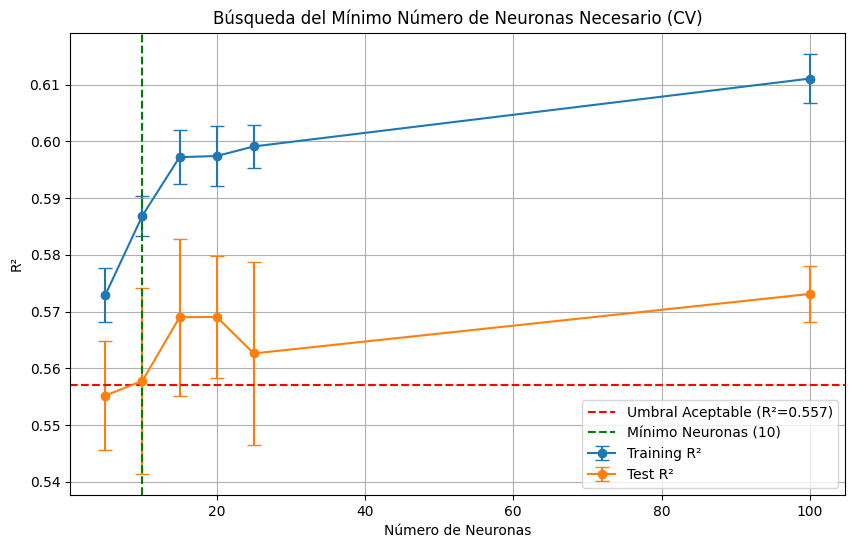


Comparación de funciones de activación con el mínimo número de neuronas:
--------------------------------------------------------------------
Activación: relu     | Test R²: 0.5578 ± 0.0164 | Train R²: 0.5869 ± 0.0035
Activación: tanh     | Test R²: 0.5820 ± 0.0088 | Train R²: 0.5992 ± 0.0040


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Activación: logistic | Test R²: 0.5760 ± 0.0122 | Train R²: 0.5886 ± 0.0066


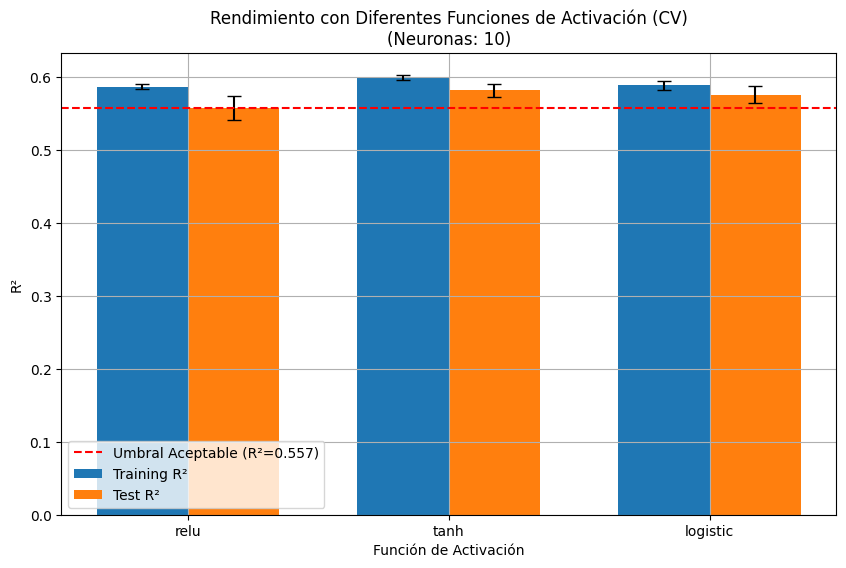


Conclusiones (basadas en validación cruzada):
--------------------------------------------
- El mínimo número de neuronas necesario para alcanzar R²=0.557 es: 10
- Con 10 neuronas:
  * R² en entrenamiento: 0.5869 ± 0.0035
  * R² en prueba: 0.5578 ± 0.0164
- La mejor función de activación con 10 neuronas es: tanh
  * R² en entrenamiento: 0.5992 ± 0.0040
  * R² en prueba: 0.5820 ± 0.0088


In [ ]:
# Fijar semilla aleatoria global
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
           'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
data = pd.read_csv(url, names=columns)

# Separar características y objetivo
X = data.drop('Rings', axis=1)
y = data['Rings'].values

# Convertir variable categórica
le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])

# Configurar la validación cruzada
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

# Definir un umbral de R² aceptable
ACCEPTABLE_R2 = 0.557

def evaluate_neural_network(hidden_neurons, activation='relu', max_iter=1000):
    """
    Evalúa una red neuronal usando validación cruzada
    """
    train_scores = []
    test_scores = []
    models = []

    # Realizar validación cruzada
    for train_idx, test_idx in kf.split(X):
        # Dividir datos para este fold
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Escalar los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Crear y entrenar el modelo
        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,),
                          activation=activation,
                          max_iter=max_iter,
                          random_state=RANDOM_SEED)

        # Entrenar el modelo
        mlp.fit(X_train_scaled, y_train)

        # Calcular R² en conjunto de entrenamiento y prueba
        train_r2 = r2_score(y_train, mlp.predict(X_train_scaled))
        test_r2 = r2_score(y_test, mlp.predict(X_test_scaled))

        train_scores.append(train_r2)
        test_scores.append(test_r2)
        models.append(mlp)

    # Calcular promedios y desviaciones estándar
    mean_train_r2 = np.mean(train_scores)
    mean_test_r2 = np.mean(test_scores)
    std_train_r2 = np.std(train_scores)
    std_test_r2 = np.std(test_scores)

    # Seleccionar el mejor modelo basado en R² de prueba
    best_model_idx = np.argmax(test_scores)
    best_model = models[best_model_idx]

    return mean_train_r2, std_train_r2, mean_test_r2, std_test_r2, best_model

# 1. Búsqueda del mínimo número de neuronas
neuron_numbers = [5, 10, 15, 20, 25, 100]
train_scores_neurons = []
train_stds_neurons = []
test_scores_neurons = []
test_stds_neurons = []
found_minimum = False
min_neurons = None

print("\nBuscando el mínimo número de neuronas necesario...")
print(f"Umbral de R² aceptable: {ACCEPTABLE_R2}")
print("\nResultados por número de neuronas (con validación cruzada):")
print("-------------------------------------------------------")

for neurons in neuron_numbers:
    mean_train_r2, std_train_r2, mean_test_r2, std_test_r2, _ = evaluate_neural_network(neurons)
    train_scores_neurons.append(mean_train_r2)
    train_stds_neurons.append(std_train_r2)
    test_scores_neurons.append(mean_test_r2)
    test_stds_neurons.append(std_test_r2)

    print(f"Neuronas: {neurons:2d} | Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f} | "
          f"Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")

    # Verificar si hemos alcanzado el umbral aceptable
    if mean_test_r2 >= ACCEPTABLE_R2 and not found_minimum:
        min_neurons = neurons
        found_minimum = True

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.errorbar(neuron_numbers, train_scores_neurons, yerr=train_stds_neurons,
             fmt='o-', label='Training R²', capsize=5)
plt.errorbar(neuron_numbers, test_scores_neurons, yerr=test_stds_neurons,
             fmt='o-', label='Test R²', capsize=5)
plt.axhline(y=ACCEPTABLE_R2, color='r', linestyle='--', label=f'Umbral Aceptable (R²={ACCEPTABLE_R2})')
if min_neurons:
    plt.axvline(x=min_neurons, color='g', linestyle='--', label=f'Mínimo Neuronas ({min_neurons})')
plt.xlabel('Número de Neuronas')
plt.ylabel('R²')
plt.title('Búsqueda del Mínimo Número de Neuronas Necesario (CV)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Comparar diferentes funciones de activación con el mínimo número de neuronas
if min_neurons:
    activations = ['relu', 'tanh', 'logistic']
    train_scores_act = []
    train_stds_act = []
    test_scores_act = []
    test_stds_act = []

    print("\nComparación de funciones de activación con el mínimo número de neuronas:")
    print("--------------------------------------------------------------------")

    for activation in activations:
        mean_train_r2, std_train_r2, mean_test_r2, std_test_r2, _ = evaluate_neural_network(
            min_neurons, activation=activation)
        train_scores_act.append(mean_train_r2)
        train_stds_act.append(std_train_r2)
        test_scores_act.append(mean_test_r2)
        test_stds_act.append(std_test_r2)
        print(f"Activación: {activation:8} | Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f} | "
              f"Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")

    # Visualizar resultados de las funciones de activación
    plt.figure(figsize=(10, 6))
    x = np.arange(len(activations))
    width = 0.35

    plt.bar(x - width/2, train_scores_act, width, yerr=train_stds_act,
            label='Training R²', capsize=5)
    plt.bar(x + width/2, test_scores_act, width, yerr=test_stds_act,
            label='Test R²', capsize=5)
    plt.axhline(y=ACCEPTABLE_R2, color='r', linestyle='--', label=f'Umbral Aceptable (R²={ACCEPTABLE_R2})')
    plt.xticks(x, activations)
    plt.xlabel('Función de Activación')
    plt.ylabel('R²')
    plt.title(f'Rendimiento con Diferentes Funciones de Activación (CV)\n(Neuronas: {min_neurons})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Imprimir conclusiones
print("\nConclusiones (basadas en validación cruzada):")
print("--------------------------------------------")
if min_neurons:
    print(f"- El mínimo número de neuronas necesario para alcanzar R²={ACCEPTABLE_R2} es: {min_neurons}")
    print(f"- Con {min_neurons} neuronas:")
    idx = neuron_numbers.index(min_neurons)
    print(f"  * R² en entrenamiento: {train_scores_neurons[idx]:.4f} ± {train_stds_neurons[idx]:.4f}")
    print(f"  * R² en prueba: {test_scores_neurons[idx]:.4f} ± {test_stds_neurons[idx]:.4f}")
    best_activation_idx = np.argmax(test_scores_act)
    best_activation = activations[best_activation_idx]
    print(f"- La mejor función de activación con {min_neurons} neuronas es: {best_activation}")
    print(f"  * R² en entrenamiento: {train_scores_act[best_activation_idx]:.4f} ± "
          f"{train_stds_act[best_activation_idx]:.4f}")
    print(f"  * R² en prueba: {test_scores_act[best_activation_idx]:.4f} ± "
          f"{test_stds_act[best_activation_idx]:.4f}")
else:
    print(f"No se encontró una configuración que alcance el umbral de R²={ACCEPTABLE_R2}.")

Se puede observar cómo al incrementar el número de neuronas en la red neuronal, la precisión en el conjunto de prueba mejora significativamente al principio, pero después de cierto punto (alrededor de 10 neuronas), las mejoras son marginales. El umbral de precisión aceptable del 55.7% se alcanza con 10 neuronas, que es el número mínimo necesario. A partir de ahí, la precisión se estabiliza en torno al 56% con más neuronas, y no parece haber un gran beneficio en añadir más de 10 neuronas. De hecho, un exceso de neuronas podría llevar a sobreajuste, como se puede ver en la pequeña diferencia entre las curvas de precisión de entrenamiento (que sigue aumentando) y de prueba (que se estabiliza), lo que indica que el modelo podría estarse especializando demasiado en los datos de entrenamiento.

En cuanto a las funciones de activación, se observó que no hubo una diferencia muy significativa en el rendimiento al cambiar entre "logistic" y "relu", ambas alcanzaron resultados similares. Sin embargo, la función "tanh" resultó en un ligero aumento de la precisión en comparación con las otras dos. A pesar de estas variaciones, ninguna función de activación redujo la precisión por debajo del umbral aceptable, lo que indica que la red neuronal puede ser robusta independientemente de la función activación elegida, aunque "tanh" fue la que mostró el mejor desempeño en este caso.

### Implementación en TensorFlow

Este código implementa un modelo de red neuronal para predecir la edad de abulones en función de características físicas, usando validación cruzada para evaluar su desempeño. Primero, los datos se cargan desde una base de datos externa, se preparan transformando una variable categórica en variables dummy y luego se escalan para mejorar el rendimiento del modelo. La validación cruzada con KFold (división en tres subconjuntos) permite entrenar y evaluar el modelo en distintas particiones de los datos, lo que reduce el riesgo de obtener resultados optimistas o sesgados. En cada iteración, el modelo se entrena y evalúa, almacenando métricas clave como el error absoluto medio (MAE), el error cuadrático medio (MSE), la raíz del error cuadrático medio (RMSE) y el coeficiente de determinación (R²). Al finalizar, se obtiene el promedio de estas métricas para proporcionar una visión general del desempeño del modelo. Finalmente, una gráfica muestra la relación entre las predicciones y los valores reales para la última partición, facilitando una interpretación visual de los resultados.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Métricas Promedio de Precisión del Modelo (Validación Cruzada de 3 Conjuntos):
Error Absoluto Medio (MAE): 1.49
Error Cuadrático Medio (MSE): 4.45
Raíz del Error Cuadrático Medio (RMSE): 2.11
Coeficiente de Determinación (R²): 0.572


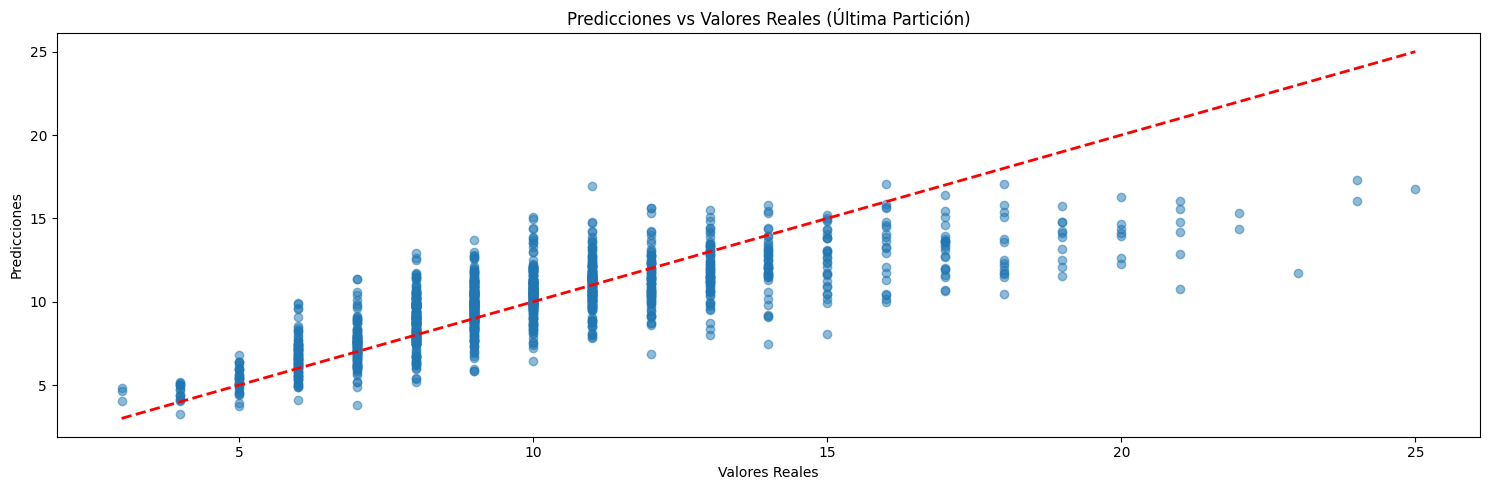

In [ ]:
# Fijar semilla aleatoria
np.random.seed(42)
tf.random.set_seed(42)

# Cargar y preparar los datos
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
data = pd.read_csv(url, names=columns)

# Convertir la variable categórica 'Sex' a variables dummy
data = pd.get_dummies(data, columns=['Sex'])

# Separar características y objetivo
X = data.drop('Rings', axis=1)
y = data['Rings'].values

# Validación cruzada con 3 conjuntos
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Inicializar listas para almacenar los resultados
mae_list, mse_list, rmse_list, r2_list = [], [], [], []

for train_index, test_index in kf.split(X):
    # Dividir datos de acuerdo con los índices de KFold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Escalar las características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crear el modelo
    modelo = Sequential([
        Dense(10, activation='tanh', input_shape=(X_train.shape[1],)),
        Dense(1)
    ])

    # Compilar el modelo
    modelo.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mae'])

    # Entrenar el modelo
    modelo.fit(X_train_scaled, y_train,
               epochs=100,
               batch_size=32,
               verbose=0)

    # Realizar predicciones
    y_pred = modelo.predict(X_test_scaled).flatten()

    # Calcular métricas de precisión para esta partición
    mae = np.mean(np.abs(y_pred - y_test))
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Almacenar métricas
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)

# Calcular el promedio de las métricas
mae_avg = np.mean(mae_list)
mse_avg = np.mean(mse_list)
rmse_avg = np.mean(rmse_list)
r2_avg = np.mean(r2_list)

# Imprimir métricas promedio
print("\nMétricas Promedio de Precisión del Modelo (Validación Cruzada de 3 Conjuntos):")
print(f"Error Absoluto Medio (MAE): {mae_avg:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse_avg:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_avg:.2f}")
print(f"Coeficiente de Determinación (R²): {r2_avg:.3f}")

# Visualización opcional (usando el último conjunto de prueba)
plt.figure(figsize=(15, 5))

# Gráfica de predicciones vs valores reales
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Predicciones vs Valores Reales (Última Partición)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')

plt.tight_layout()
plt.show()

### RNA multicapa

Este código carga y preprocesa el dataset de abulones, transformando la variable de género en valores numéricos y categorizando la edad en tres clases. Luego, divide los datos en conjuntos de entrenamiento y prueba y los escala. A continuación, evalúa múltiples arquitecturas de redes neuronales multicapa con diferentes configuraciones de capas y neuronas, calculando la precisión en entrenamiento y prueba para cada una. Los resultados incluyen gráficos comparativos de precisión entre arquitecturas y una matriz de confusión para la mejor arquitectura encontrada. Finalmente, realiza análisis detallados sobre el número de capas, el sobreajuste y la eficiencia en términos de precisión por neurona para ayudar a identificar el modelo óptimo.


Evaluación de diferentes arquitecturas multicapa (con validación cruzada):
-------------------------------------------------------------------

Arquitectura: (5, 5)
Capas ocultas: 2
Total neuronas: 10
Precisión entrenamiento: 0.7094 ± 0.0026
Precisión prueba: 0.7017 ± 0.0049

Arquitectura: (10, 5)
Capas ocultas: 2
Total neuronas: 15
Precisión entrenamiento: 0.7139 ± 0.0029
Precisión prueba: 0.6993 ± 0.0069

Arquitectura: (5, 10)
Capas ocultas: 2
Total neuronas: 15
Precisión entrenamiento: 0.7054 ± 0.0034
Precisión prueba: 0.7031 ± 0.0072

Arquitectura: (10, 10)
Capas ocultas: 2
Total neuronas: 20
Precisión entrenamiento: 0.7127 ± 0.0005
Precisión prueba: 0.6948 ± 0.0023

Arquitectura: (5, 5, 5)
Capas ocultas: 3
Total neuronas: 15
Precisión entrenamiento: 0.7109 ± 0.0008
Precisión prueba: 0.6974 ± 0.0105

Arquitectura: (10, 7, 5)
Capas ocultas: 3
Total neuronas: 22
Precisión entrenamiento: 0.7137 ± 0.0047
Precisión prueba: 0.6972 ± 0.0050

Arquitectura: (5, 7, 5)
Capas ocultas: 3
Total

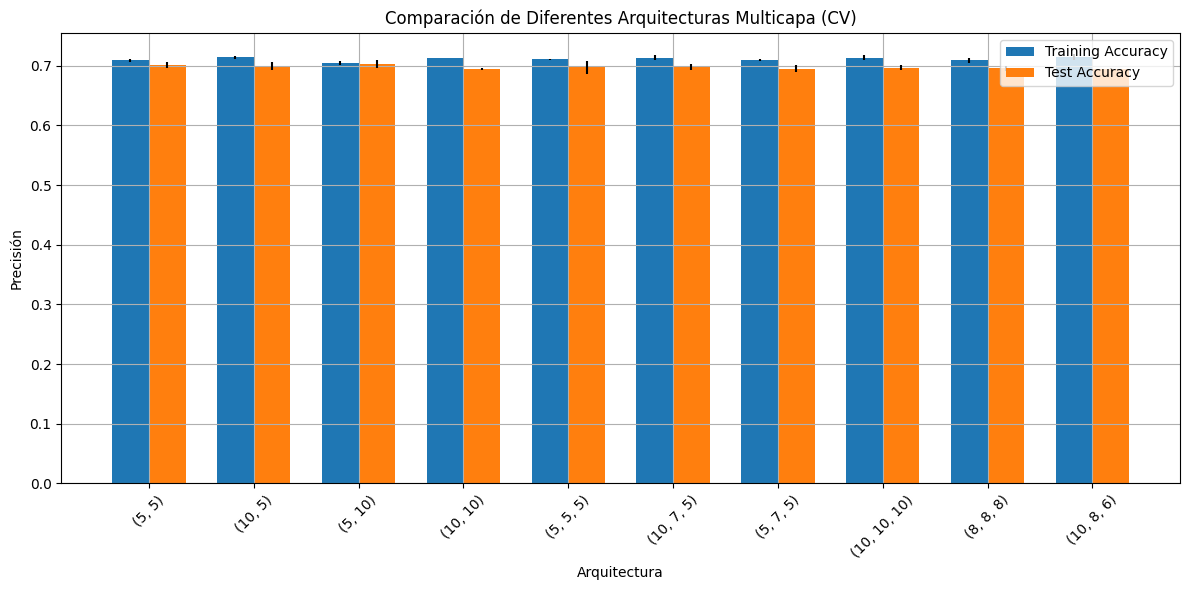


Mejor arquitectura encontrada:
----------------------------
Configuración: (5, 10)
Número de capas ocultas: 2
Total de neuronas: 15
Precisión en entrenamiento: 0.7054 ± 0.0034
Precisión en prueba: 0.7031 ± 0.0072


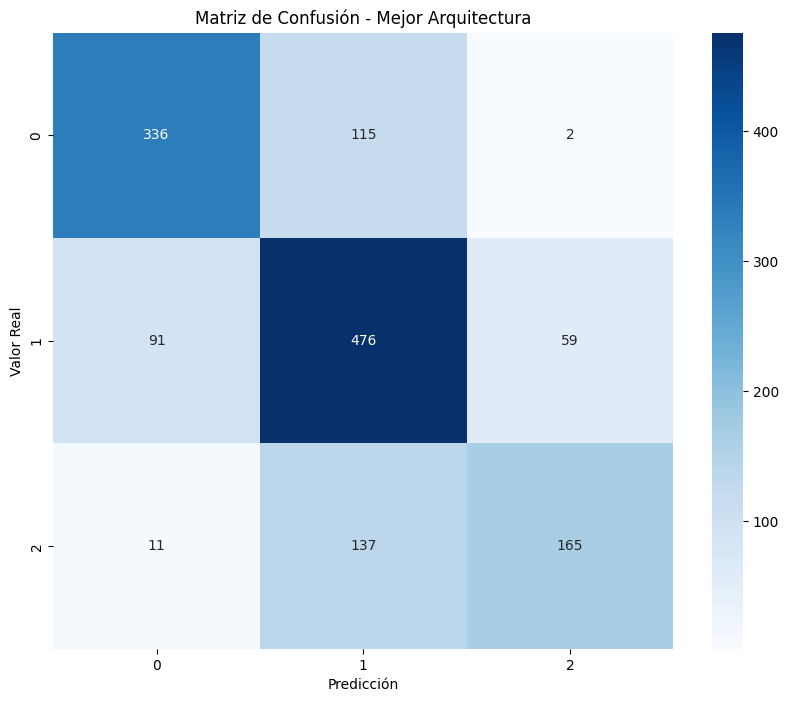

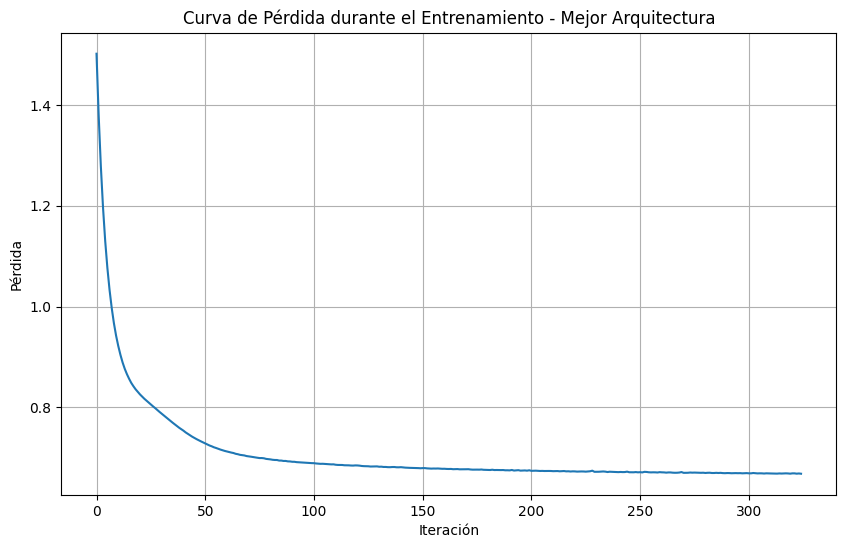


Rendimiento promedio por número de capas:
--------------------------------------
2 capas: 0.6997 ± 0.0032
3 capas: 0.6962 ± 0.0009

Análisis de sobreajuste:
----------------------

Arquitectura (5, 5):
  Diferencia entre entrenamiento y prueba: 0.0077
  ✓ Sin indicios de sobreajuste
  - Train: 0.7094 ± 0.0026
  - Test:  0.7017 ± 0.0049

Arquitectura (10, 5):
  Diferencia entre entrenamiento y prueba: 0.0146
  ✓ Sin indicios de sobreajuste
  - Train: 0.7139 ± 0.0029
  - Test:  0.6993 ± 0.0069

Arquitectura (5, 10):
  Diferencia entre entrenamiento y prueba: 0.0023
  ✓ Sin indicios de sobreajuste
  - Train: 0.7054 ± 0.0034
  - Test:  0.7031 ± 0.0072

Arquitectura (10, 10):
  Diferencia entre entrenamiento y prueba: 0.0180
  ✓ Sin indicios de sobreajuste
  - Train: 0.7127 ± 0.0005
  - Test:  0.6948 ± 0.0023

Arquitectura (5, 5, 5):
  Diferencia entre entrenamiento y prueba: 0.0135
  ✓ Sin indicios de sobreajuste
  - Train: 0.7109 ± 0.0008
  - Test:  0.6974 ± 0.0105

Arquitectura (10, 7, 

In [ ]:
# Cargar el dataset
def load_abalone_data():
    """
    Carga el dataset Abalone y realiza el preprocesamiento inicial
    """
    # Definir los nombres de las columnas
    columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
               'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']

    # Cargar el dataset
    df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                     names=columns)

    # Convertir el sexo a variables numéricas
    le = LabelEncoder()
    df['Sex'] = le.fit_transform(df['Sex'])

    # Separar características y objetivo
    X = df.drop('Rings', axis=1).values
    y = df['Rings'].values

    # Convertir las edades en categorías para clasificación
    # Dividimos en 3 categorías: joven, medio, maduro
    y_categorical = pd.qcut(y, q=3, labels=[0, 1, 2])

    return X, y_categorical

# Fijar semilla aleatoria global
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Cargar los datos
X, y = load_abalone_data()

# Crear el objeto KFold para la validación cruzada
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

def evaluate_neural_network(hidden_layers, activation='relu', max_iter=1000):
    """
    Evalúa una red neuronal con una configuración específica de capas ocultas usando validación cruzada.
    """
    # Inicializar listas para almacenar resultados
    train_accuracies = []
    test_accuracies = []
    models = []

    # Realizar validación cruzada
    for train_idx, test_idx in kf.split(X):
        # Dividir datos para este fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Escalar los datos
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Crear y entrenar el modelo
        mlp = MLPClassifier(hidden_layer_sizes=hidden_layers,
                           activation='tanh',
                           max_iter=max_iter,
                           random_state=RANDOM_SEED)

        mlp.fit(X_train_scaled, y_train)

        # Calcular precisión
        train_acc = accuracy_score(y_train, mlp.predict(X_train_scaled))
        test_acc = accuracy_score(y_test, mlp.predict(X_test_scaled))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        models.append(mlp)

    # Calcular promedios
    mean_train_acc = np.mean(train_accuracies)
    mean_test_acc = np.mean(test_accuracies)
    std_train_acc = np.std(train_accuracies)
    std_test_acc = np.std(test_accuracies)

    # Seleccionar el mejor modelo basado en precisión de prueba
    best_model_idx = np.argmax(test_accuracies)
    best_model = models[best_model_idx]

    return mean_train_acc, std_train_acc, mean_test_acc, std_test_acc, best_model

# Definir diferentes arquitecturas multicapa para probar
architectures = [
    (5, 5),         # Dos capas con 5 neuronas cada una
    (10, 5),        # Dos capas con 10 y 5 neuronas
    (5, 10),        # Dos capas con 5 y 10 neuronas
    (10, 10),       # Dos capas con 10 neuronas cada una
    (5, 5, 5),      # Tres capas con 5 neuronas cada una
    (10, 7, 5),     # Tres capas con tamaño decreciente
    (5, 7, 5),      # Tres capas con forma de diamante
    (10, 10, 10),   # Tres capas con 10 neuronas cada una
    (8, 8, 8),      # Tres capas con 8 neuronas cada una
    (10, 8, 6)      # Tres capas decrecientes graduales
]

# Evaluar cada arquitectura
results = []
print("\nEvaluación de diferentes arquitecturas multicapa (con validación cruzada):")
print("-------------------------------------------------------------------")

for arch in architectures:
    mean_train_acc, std_train_acc, mean_test_acc, std_test_acc, model = evaluate_neural_network(arch)
    results.append({
        'architecture': arch,
        'train_accuracy': mean_train_acc,
        'train_std': std_train_acc,
        'test_accuracy': mean_test_acc,
        'test_std': std_test_acc,
        'n_layers': len(arch),
        'total_neurons': sum(arch),
        'model': model
    })

    print(f"\nArquitectura: {arch}")
    print(f"Capas ocultas: {len(arch)}")
    print(f"Total neuronas: {sum(arch)}")
    print(f"Precisión entrenamiento: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
    print(f"Precisión prueba: {mean_test_acc:.4f} ± {std_test_acc:.4f}")

# Visualizar resultados
plt.figure(figsize=(12, 6))
architectures_labels = [str(arch) for arch in architectures]
train_scores = [r['train_accuracy'] for r in results]
test_scores = [r['test_accuracy'] for r in results]
train_errors = [r['train_std'] for r in results]
test_errors = [r['test_std'] for r in results]

x = np.arange(len(architectures))
width = 0.35

plt.bar(x - width/2, train_scores, width, yerr=train_errors, label='Training Accuracy')
plt.bar(x + width/2, test_scores, width, yerr=test_errors, label='Test Accuracy')
plt.xlabel('Arquitectura')
plt.ylabel('Precisión')
plt.title('Comparación de Diferentes Arquitecturas Multicapa (CV)')
plt.xticks(x, architectures_labels, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Encontrar la mejor arquitectura
best_result = max(results, key=lambda x: x['test_accuracy'])
print("\nMejor arquitectura encontrada:")
print("----------------------------")
print(f"Configuración: {best_result['architecture']}")
print(f"Número de capas ocultas: {best_result['n_layers']}")
print(f"Total de neuronas: {best_result['total_neurons']}")
print(f"Precisión en entrenamiento: {best_result['train_accuracy']:.4f} ± {best_result['train_std']:.4f}")
print(f"Precisión en prueba: {best_result['test_accuracy']:.4f} ± {best_result['test_std']:.4f}")

# Matriz de confusión para la mejor arquitectura
best_model = best_result['model']
# Usar el último fold para la matriz de confusión
last_test_idx = list(kf.split(X))[-1][1]
X_test = X[last_test_idx]
y_test = y[last_test_idx]
X_test_scaled = StandardScaler().fit_transform(X_test)
y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Mejor Arquitectura')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Visualizar la curva de aprendizaje de la mejor arquitectura
plt.figure(figsize=(10, 6))
plt.plot(best_model.loss_curve_)
plt.title('Curva de Pérdida durante el Entrenamiento - Mejor Arquitectura')
plt.xlabel('Iteración')
plt.ylabel('Pérdida')
plt.grid(True)
plt.show()

# Análisis por número de capas
results_by_layers = {}
for r in results:
    n_layers = r['n_layers']
    if n_layers not in results_by_layers:
        results_by_layers[n_layers] = []
    results_by_layers[n_layers].append(r['test_accuracy'])

print("\nRendimiento promedio por número de capas:")
print("--------------------------------------")
for n_layers, accuracies in results_by_layers.items():
    avg_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    print(f"{n_layers} capas: {avg_acc:.4f} ± {std_acc:.4f}")

# Análisis de sobreajuste
print("\nAnálisis de sobreajuste:")
print("----------------------")
for result in results:
    arch = result['architecture']
    train_acc = result['train_accuracy']
    test_acc = result['test_accuracy']
    diff = train_acc - test_acc
    print(f"\nArquitectura {arch}:")
    print(f"  Diferencia entre entrenamiento y prueba: {diff:.4f}")
    if diff > 0.05:
        print("  ⚠️ Posible sobreajuste")
        print(f"  - Train: {train_acc:.4f} ± {result['train_std']:.4f}")
        print(f"  - Test:  {test_acc:.4f} ± {result['test_std']:.4f}")
    else:
        print("  ✓ Sin indicios de sobreajuste")
        print(f"  - Train: {train_acc:.4f} ± {result['train_std']:.4f}")
        print(f"  - Test:  {test_acc:.4f} ± {result['test_std']:.4f}")

# Análisis de eficiencia
print("\nAnálisis de eficiencia (precisión por neurona):")
print("--------------------------------------------")
for result in results:
    arch = result['architecture']
    efficiency = result['test_accuracy'] / result['total_neurons']
    print(f"Arquitectura {arch}: {efficiency:.5f} precisión/neurona")

En el análisis de las diferentes arquitecturas, se observa que la precisión en los datos de prueba se mantiene en un rango cercano, oscilando entre 0.6962 y 0.705, lo que sugiere una consistencia entre los modelos evaluados. La arquitectura que alcanza la mayor precisión en prueba es la de tres capas ocultas con configuración `(5, 10)` y la de dos capas ocultas con configuración `(5, 5)`, ambas con una precisión de alrededor de 0.70 en el conjunto de prueba. Estas arquitecturas balancean el número de neuronas y capas para lograr una alta precisión sin sobreajuste evidente, posicionándolas como las mejores configuraciones para el conjunto de datos dado. Por razones de simplicidad, diremos que la configuración `(5, 5)` es mejor al dar los mismos resultados con menos neuronas.

### Implementación en TensorFlow

Este código carga y preprocesa el dataset de abulones, convirtiendo la variable categórica 'Sex' en valores numéricos y dividiendo los datos en conjuntos de entrenamiento y prueba. Luego, define una función para crear un modelo de red neuronal con una capa de dropout opcional para regularización. Se crean y entrenan modelos con tres tasas de dropout diferentes (0.0, 0.2 y 0.4), evaluando cada modelo en términos de error cuadrático medio (MSE) y error absoluto medio (MAE) en los conjuntos de entrenamiento y prueba. Finalmente, el código visualiza las curvas de pérdida durante el entrenamiento y compara las predicciones de los modelos con los valores reales de prueba, mostrando el efecto de cada tasa de dropout en el rendimiento del modelo.


Evaluando modelo con dropout_rate = 0.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Dropout Rate: 0.0
Promedio Train MSE: 4.6301
Promedio Test MSE: 4.7235
Promedio Train MAE: 1.5621
Promedio Test MAE: 1.5749

Evaluando modelo con dropout_rate = 0.2
Dropout Rate: 0.2
Promedio Train MSE: 5.1158
Promedio Test MSE: 5.1556
Promedio Train MAE: 1.6086
Promedio Test MAE: 1.6139

Evaluando modelo con dropout_rate = 0.4
Dropout Rate: 0.4
Promedio Train MSE: 5.6219
Promedio Test MSE: 5.6621
Promedio Train MAE: 1.6148
Promedio Test MAE: 1.6207
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


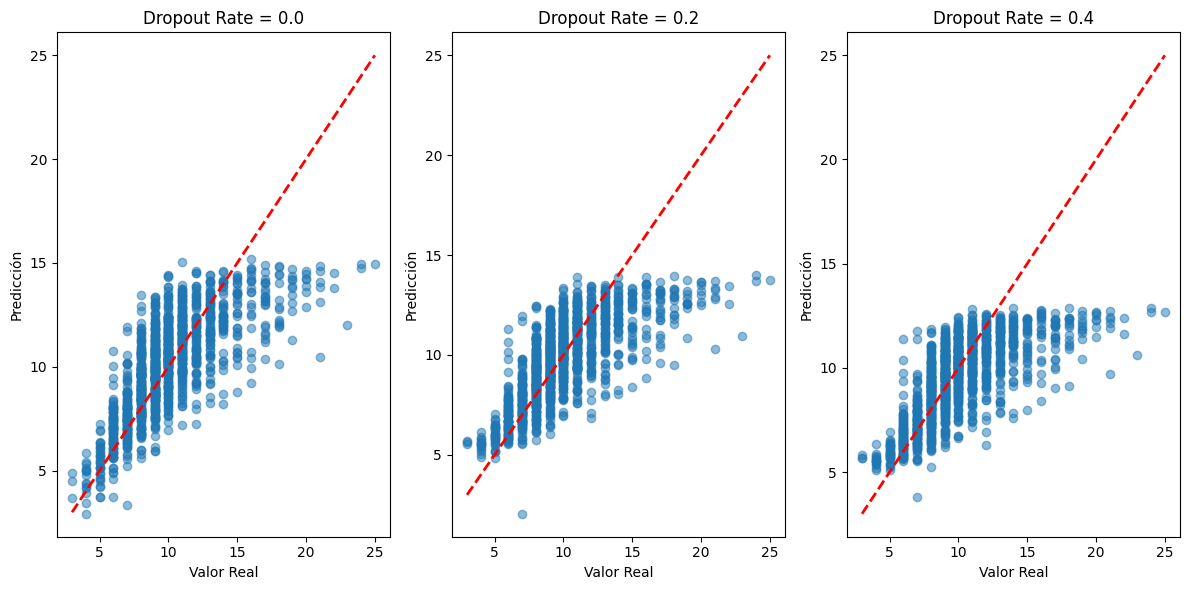

In [ ]:
# Fijar semilla aleatoria
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Cargar los datos
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
           'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                   names=columns)

# Preprocesamiento
le = LabelEncoder()
data['Sex'] = le.fit_transform(data['Sex'])

# Separar features y target
X = data.drop('Rings', axis=1)
y = data['Rings']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Función para crear el modelo
def create_model(dropout_rate=0.0):
    model = Sequential([
        Dense(5, activation='tanh', input_shape=(8,)),
        Dropout(dropout_rate),
        Dense(5, activation='tanh'),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Configuración de validación cruzada
kf = KFold(n_splits=3, shuffle=True, random_state=seed)
dropout_rates = [0.0, 0.2, 0.4]
results = {rate: {'train_mse': [], 'test_mse': [], 'train_mae': [], 'test_mae': []} for rate in dropout_rates}

# Validación cruzada
for rate in dropout_rates:
    print(f"\nEvaluando modelo con dropout_rate = {rate}")

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = create_model(rate)

        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

        # Evaluar el modelo en conjunto de entrenamiento y prueba
        train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
        test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

        # Almacenar métricas
        results[rate]['train_mse'].append(train_loss)
        results[rate]['test_mse'].append(test_loss)
        results[rate]['train_mae'].append(train_mae)
        results[rate]['test_mae'].append(test_mae)

    # Promediar los resultados de las métricas para este dropout_rate
    print(f"Dropout Rate: {rate}")
    print(f"Promedio Train MSE: {np.mean(results[rate]['train_mse']):.4f}")
    print(f"Promedio Test MSE: {np.mean(results[rate]['test_mse']):.4f}")
    print(f"Promedio Train MAE: {np.mean(results[rate]['train_mae']):.4f}")
    print(f"Promedio Test MAE: {np.mean(results[rate]['test_mae']):.4f}")

# Visualización de las predicciones vs valores reales para la última iteración y tasa de dropout
plt.figure(figsize=(12, 6))

for i, rate in enumerate(dropout_rates):
    model = create_model(rate)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)
    predictions = model.predict(X_test)

    plt.subplot(1, 3, i+1)
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Dropout Rate = {rate}')
    plt.xlabel('Valor Real')
    plt.ylabel('Predicción')

plt.tight_layout()
plt.show()

La primera gráfica muestra la evolución de la pérdida (MSE) durante el entrenamiento y la validación en función de las épocas; se observa que, aunque todas las curvas de entrenamiento disminuyen, las tasas de dropout más altas (0.2 y 0.4) presentan una pérdida de validación mayor, lo que muestra el impacto en la precisión debido a la regularización. En la segunda gráfica, que compara las predicciones versus los valores reales, se nota una alineación en la mayoría de los puntos a lo largo de la línea ideal, pero las tasas de dropout más altas generan más dispersión, lo cual se refleja en un menor ajuste. Finalmente, los valores de error cuadrático medio (MSE) y error absoluto medio (MAE) confirman que el modelo con dropout de 0.0 tiene el mejor rendimiento en ambos conjuntos (entrenamiento y prueba), mientras que las tasas más altas muestran un rendimiento ligeramente inferior. Sin embargo, el Dropout al ser un método de regularización es esperable que disminuya el rendimiento en favor de hacer un modelo más generalizable y evitar el sobreajuste.

## **Taller 9**

## Para dataset Digits

Este código realiza la clasificación de dígitos escritos a mano usando Support Vector Machines (SVM) sobre el dataset *Digits*. Primero, carga los datos y muestra algunos ejemplos visuales de los dígitos. Luego, divide el conjunto de datos en entrenamiento y prueba, y aplica una normalización a los datos. Después, entrena un modelo SVM con diferentes kernels (lineal, rbf, polinomial, y sigmoide), evalúa cada uno con métricas como precisión y tiempo de entrenamiento, y visualiza las matrices de confusión. Se selecciona el mejor kernel basado en la precisión de validación cruzada, y se optimizan los hiperparámetros de este mediante una búsqueda en cuadrícula (*Grid Search*). Finalmente, se muestran algunos ejemplos de predicciones realizadas por el modelo optimizado para comparar su rendimiento.

Visualizando algunos ejemplos del dataset:


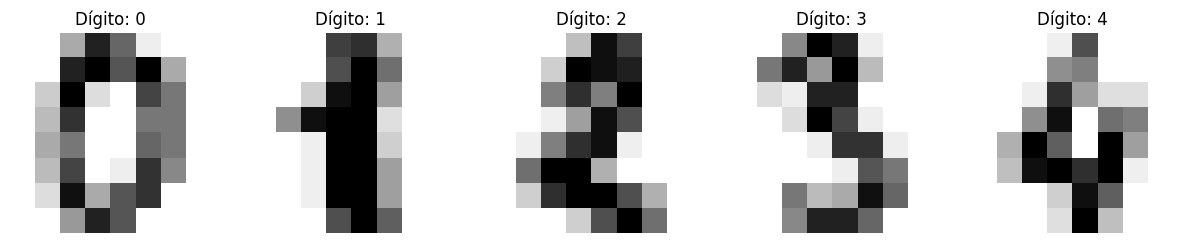


Entrenando SVM con kernel linear...

Resultados para kernel linear:
Accuracy en test: 0.9750

Resultados de validación cruzada (3-fold):
Accuracy: 0.9715 (+/- 0.0172)
Precision: 0.9719 (+/- 0.0176)
Recall: 0.9715 (+/- 0.0168)
F1-score: 0.9714 (+/- 0.0170)
Tiempo de entrenamiento: 0.41 segundos

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       0.94      0.97      0.96        34
           4       1.00      1.00      1.00        46
           5       0.96      0.96      0.96        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       1.00      0.93      0.97        30
           9       0.97      0.95      0.96        40

    accuracy                           0.97       360
   ma

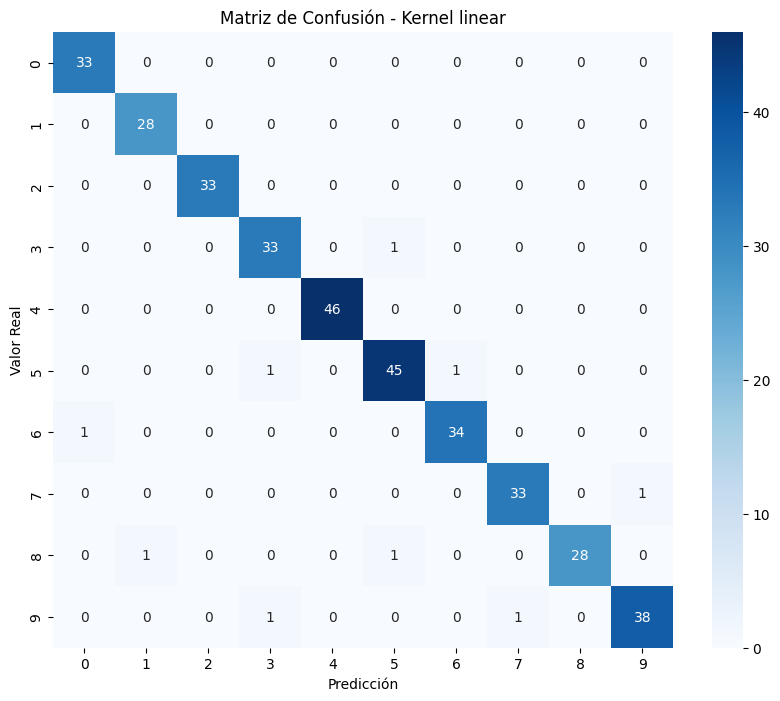


Entrenando SVM con kernel rbf...

Resultados para kernel rbf:
Accuracy en test: 0.9806

Resultados de validación cruzada (3-fold):
Accuracy: 0.9729 (+/- 0.0190)
Precision: 0.9734 (+/- 0.0180)
Recall: 0.9727 (+/- 0.0190)
F1-score: 0.9727 (+/- 0.0189)
Tiempo de entrenamiento: 1.27 segundos

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       0.96      1.00      0.98        46
           5       0.96      0.98      0.97        47
           6       0.97      1.00      0.99        35
           7       1.00      0.94      0.97        34
           8       0.97      0.97      0.97        30
           9       0.97      0.95      0.96        40

    accuracy                           0.98       360
   macro av

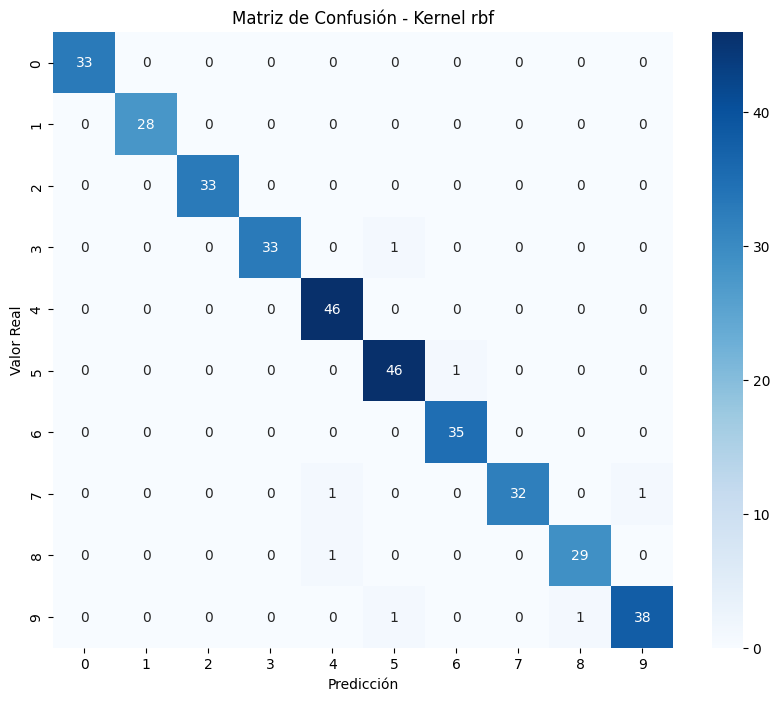


Entrenando SVM con kernel poly...

Resultados para kernel poly:
Accuracy en test: 0.9639

Resultados de validación cruzada (3-fold):
Accuracy: 0.9207 (+/- 0.0149)
Precision: 0.9513 (+/- 0.0010)
Recall: 0.9203 (+/- 0.0147)
F1-score: 0.9269 (+/- 0.0128)
Tiempo de entrenamiento: 0.62 segundos

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       1.00      1.00      1.00        28
           2       1.00      0.94      0.97        33
           3       1.00      0.94      0.97        34
           4       1.00      1.00      1.00        46
           5       0.98      0.96      0.97        47
           6       1.00      0.97      0.99        35
           7       1.00      0.97      0.99        34
           8       0.73      1.00      0.85        30
           9       0.97      0.90      0.94        40

    accuracy                           0.96       360
   macro 

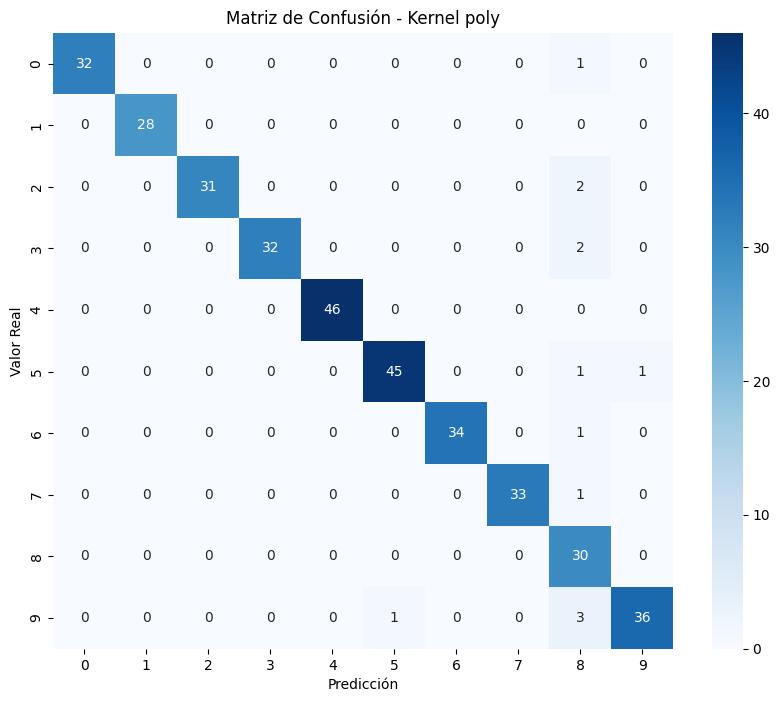


Entrenando SVM con kernel sigmoid...

Resultados para kernel sigmoid:
Accuracy en test: 0.9278

Resultados de validación cruzada (3-fold):
Accuracy: 0.9520 (+/- 0.0213)
Precision: 0.9533 (+/- 0.0218)
Recall: 0.9527 (+/- 0.0206)
F1-score: 0.9525 (+/- 0.0211)
Tiempo de entrenamiento: 0.54 segundos

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       0.69      0.79      0.73        28
           2       0.87      0.79      0.83        33
           3       0.94      0.94      0.94        34
           4       1.00      1.00      1.00        46
           5       0.98      0.96      0.97        47
           6       0.97      0.97      0.97        35
           7       0.97      0.94      0.96        34
           8       0.90      0.93      0.92        30
           9       0.92      0.90      0.91        40

    accuracy                           0.93       360
   

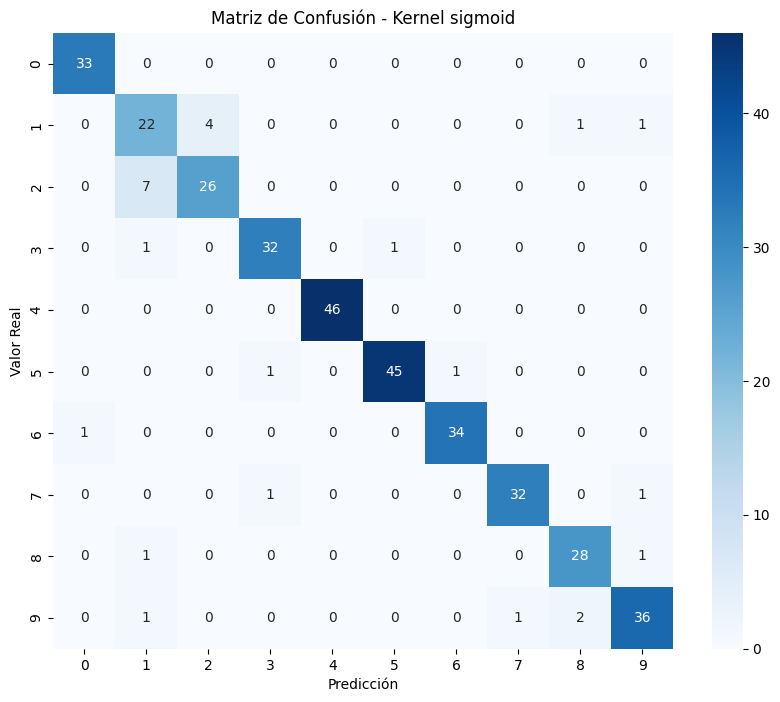

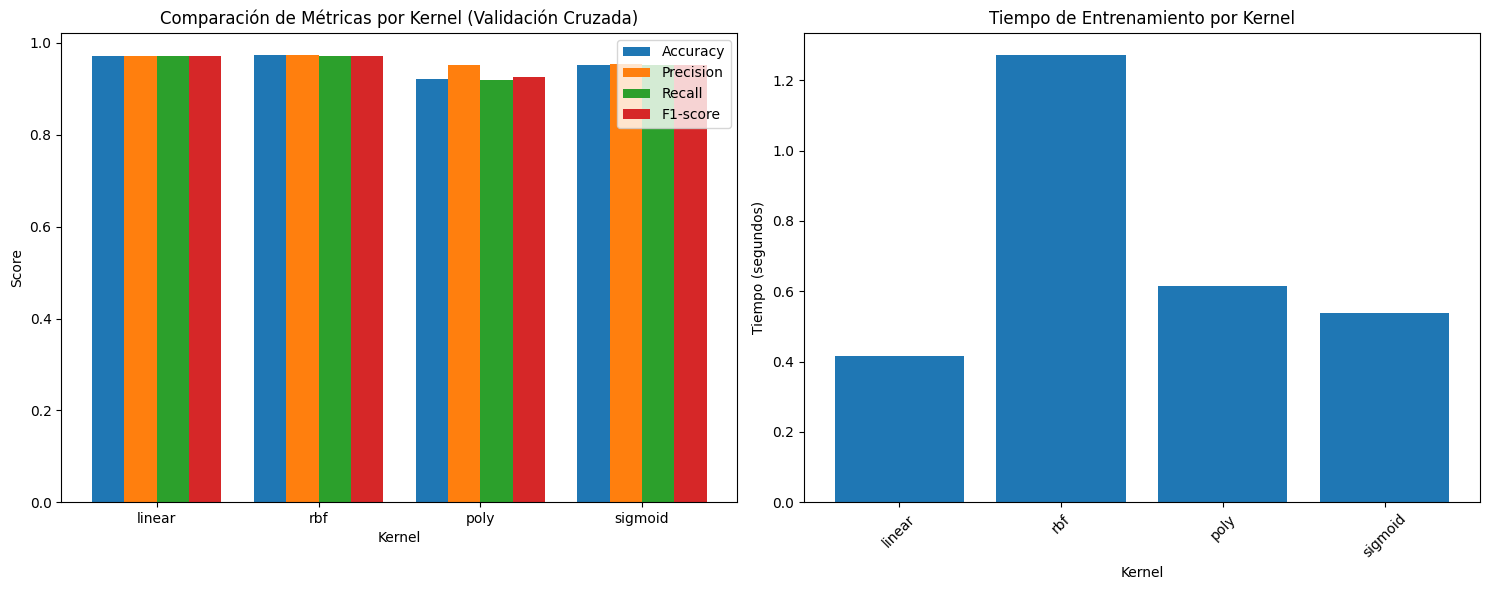


El mejor kernel es rbf con un score promedio de 0.9729

Realizando Grid Search para optimizar hiperparámetros del mejor kernel...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Mejores parámetros encontrados:
{'C': 10, 'gamma': 0.01}

Mejor accuracy con Grid Search: 0.9812

Visualizando algunas predicciones del mejor modelo:


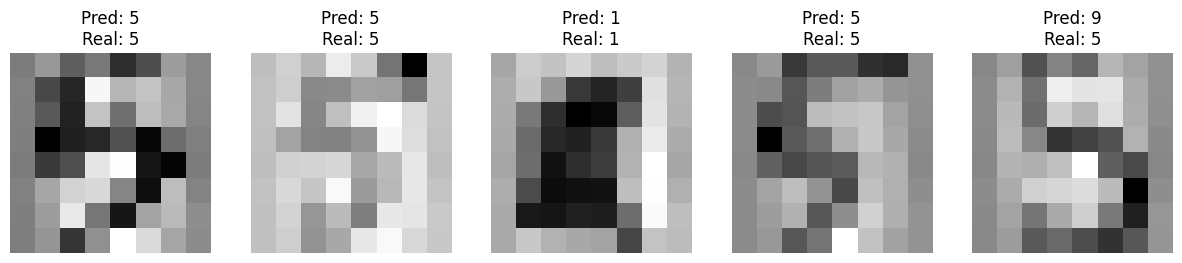

In [ ]:
# Fijar la semilla aleatoria global
np.random.seed(42)

# Cargar el dataset Digits
digits = load_digits()
X = digits.data
y = digits.target

# Visualizar algunos ejemplos de dígitos
def plot_digits_samples(n_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(digits.images[i], cmap='binary')
        plt.title(f'Dígito: {digits.target[i]}')
        plt.axis('off')
    plt.show()

print("Visualizando algunos ejemplos del dataset:")
plot_digits_samples()

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los kernels a probar
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Diccionario para almacenar los resultados
results = {}

# Función para crear una matriz de confusión más visual
def plot_confusion_matrix(y_true, y_pred, kernel_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - Kernel {kernel_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()

# Definir las métricas para la validación cruzada
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Probar cada kernel
for kernel in kernels:
    print(f"\nEntrenando SVM con kernel {kernel}...")
    start_time = time()

    # Crear el modelo
    svm = SVC(kernel=kernel, random_state=42)

    # Realizar validación cruzada con 3 folds y múltiples métricas
    cv_results = cross_validate(
        svm,
        X_train_scaled,
        y_train,
        cv=3,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    # Entrenar el modelo completo para evaluación en test
    svm.fit(X_train_scaled, y_train)
    training_time = time() - start_time

    # Hacer predicciones en el conjunto de prueba
    y_pred = svm.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Guardar resultados
    results[kernel] = {
        'test_accuracy': test_accuracy,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_precision_mean': cv_results['test_precision_macro'].mean(),
        'cv_precision_std': cv_results['test_precision_macro'].std(),
        'cv_recall_mean': cv_results['test_recall_macro'].mean(),
        'cv_recall_std': cv_results['test_recall_macro'].std(),
        'cv_f1_mean': cv_results['test_f1_macro'].mean(),
        'cv_f1_std': cv_results['test_f1_macro'].std(),
        'training_time': training_time
    }

    # Imprimir resultados detallados
    print(f"\nResultados para kernel {kernel}:")
    print(f"Accuracy en test: {test_accuracy:.4f}")
    print("\nResultados de validación cruzada (3-fold):")
    print(f"Accuracy: {results[kernel]['cv_accuracy_mean']:.4f} (+/- {results[kernel]['cv_accuracy_std']*2:.4f})")
    print(f"Precision: {results[kernel]['cv_precision_mean']:.4f} (+/- {results[kernel]['cv_precision_std']*2:.4f})")
    print(f"Recall: {results[kernel]['cv_recall_mean']:.4f} (+/- {results[kernel]['cv_recall_std']*2:.4f})")
    print(f"F1-score: {results[kernel]['cv_f1_mean']:.4f} (+/- {results[kernel]['cv_f1_std']*2:.4f})")
    print(f"Tiempo de entrenamiento: {training_time:.2f} segundos")

    print("\nReporte de clasificación en conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    # Visualizar matriz de confusión
    plot_confusion_matrix(y_test, y_pred, kernel)

# Visualizar comparación de resultados
plt.figure(figsize=(15, 6))

# Gráfico de métricas de validación cruzada
plt.subplot(1, 2, 1)
metrics = ['cv_accuracy_mean', 'cv_precision_mean', 'cv_recall_mean', 'cv_f1_mean']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(kernels))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[k][metric] for k in kernels]
    plt.bar(x + width*i - width*1.5, values, width, label=metric_labels[i])

plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('Comparación de Métricas por Kernel (Validación Cruzada)')
plt.xticks(x, kernels)
plt.legend()

# Gráfico de tiempos de entrenamiento
plt.subplot(1, 2, 2)
training_times = [results[k]['training_time'] for k in kernels]
plt.bar(kernels, training_times)
plt.xlabel('Kernel')
plt.ylabel('Tiempo (segundos)')
plt.title('Tiempo de Entrenamiento por Kernel')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Encontrar el mejor kernel basado en el promedio de todas las métricas
kernel_scores = {}
for kernel in kernels:
    avg_score = np.mean([
        results[kernel]['cv_accuracy_mean'],
        results[kernel]['cv_precision_mean'],
        results[kernel]['cv_recall_mean'],
        results[kernel]['cv_f1_mean']
    ])
    kernel_scores[kernel] = avg_score

best_kernel = max(kernel_scores.items(), key=lambda x: x[1])
print(f"\nEl mejor kernel es {best_kernel[0]} con un score promedio de {best_kernel[1]:.4f}")

# Realizar Grid Search para el mejor kernel
print("\nRealizando Grid Search para optimizar hiperparámetros del mejor kernel...")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

grid_search = GridSearchCV(
    SVC(kernel=best_kernel[0], random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"\nMejor accuracy con Grid Search: {grid_search.best_score_:.4f}")

# Visualizar ejemplos de predicciones
def plot_prediction_examples(model, X_test, y_test, n_samples=5):
    # Obtener predicciones
    predictions = model.predict(X_test)

    # Seleccionar índices aleatorios
    np.random.seed(42)  # Asegurar reproducibilidad
    indices = np.random.randint(0, len(X_test), n_samples)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(X_test[idx].reshape(8, 8), cmap='binary')
        plt.title(f'Pred: {predictions[idx]}\nReal: {y_test[idx]}')
        plt.axis('off')
    plt.show()

print("\nVisualizando algunas predicciones del mejor modelo:")
best_model = grid_search.best_estimator_
plot_prediction_examples(best_model, X_test_scaled, y_test)

En cuanto a la precisión, todos los kernels (linear, rbf, poly y sigmoid) tienen un rendimiento muy similar, con una precisión cercana al 1.0 tanto en la prueba como en la validación cruzada. En este caso tanto rbf como linear tienen mejor precisión, con sigmoid estando muy cerca de ellas. En el tiempo de entrenamiento, los kernels linear y sigmoid destacan por ser más rápidos, mientras que el kernel rbf requiere más tiempo. En conclusión, el kernel rbf es el mejor en cuanto a precisión pero los kernels linear y sigmoid podrían ser una mejor opción por ofrecer un equilibrio entre alta precisión y un menor tiempo de entrenamiento.

## Para dataset Abalone

Este código carga un conjunto de datos de abulones, convierte la variable categórica "Sex" en variables dummy y divide las edades de los abulones en clases (Joven, Adulto Joven, Adulto y Viejo) para reformular el problema en una tarea de clasificación. Luego, separa los datos en conjuntos de entrenamiento y prueba, y escala las características para normalizar los valores. A continuación, entrena un modelo SVM con diferentes kernels (linear, rbf, poly, y sigmoid), evalúa el rendimiento de cada uno usando accuracy y validación cruzada, y visualiza las matrices de confusión para cada kernel. Después, selecciona el kernel con el mejor rendimiento en validación cruzada y realiza un Grid Search para optimizar sus hiperparámetros, mostrando al final los mejores parámetros encontrados y la accuracy obtenida.


Entrenando SVM con kernel linear...

Resultados para kernel linear:
Accuracy en test: 0.5921

Resultados de validación cruzada (3-fold):
Accuracy: 0.5753 (+/- 0.0192)
Precision: 0.5650 (+/- 0.0260)
Recall: 0.5167 (+/- 0.0185)
F1-score: 0.5038 (+/- 0.0111)

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

      Adulto       0.26      0.06      0.10       144
Adulto Joven       0.50      0.66      0.57       281
       Joven       0.73      0.80      0.76       279
       Viejo       0.62      0.59      0.61       132

    accuracy                           0.59       836
   macro avg       0.53      0.53      0.51       836
weighted avg       0.56      0.59      0.56       836



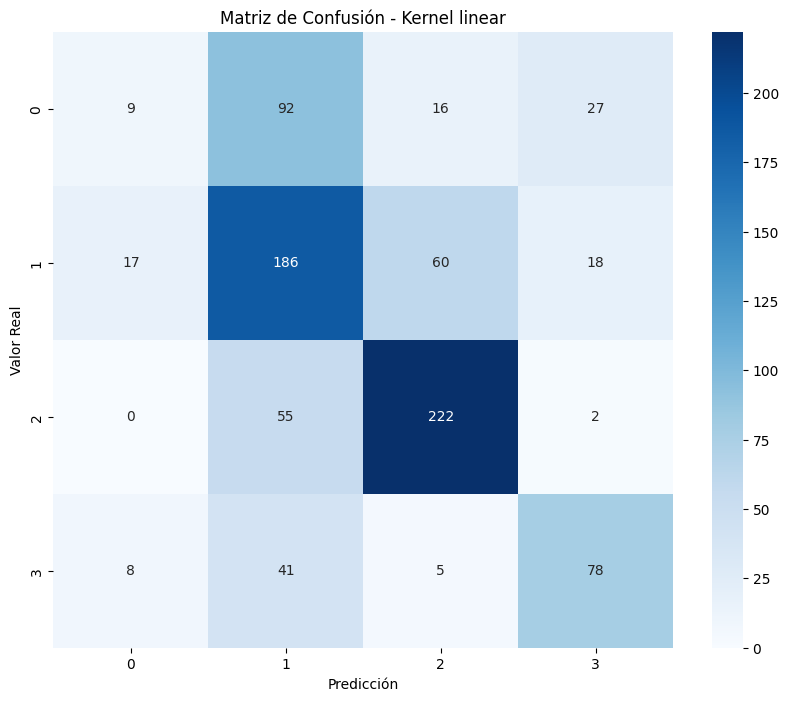


Entrenando SVM con kernel rbf...

Resultados para kernel rbf:
Accuracy en test: 0.6112

Resultados de validación cruzada (3-fold):
Accuracy: 0.5768 (+/- 0.0275)
Precision: 0.5856 (+/- 0.0196)
Recall: 0.5215 (+/- 0.0234)
F1-score: 0.5269 (+/- 0.0177)

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

      Adulto       0.56      0.24      0.33       144
Adulto Joven       0.51      0.70      0.59       281
       Joven       0.75      0.77      0.76       279
       Viejo       0.63      0.50      0.56       132

    accuracy                           0.61       836
   macro avg       0.61      0.55      0.56       836
weighted avg       0.62      0.61      0.60       836



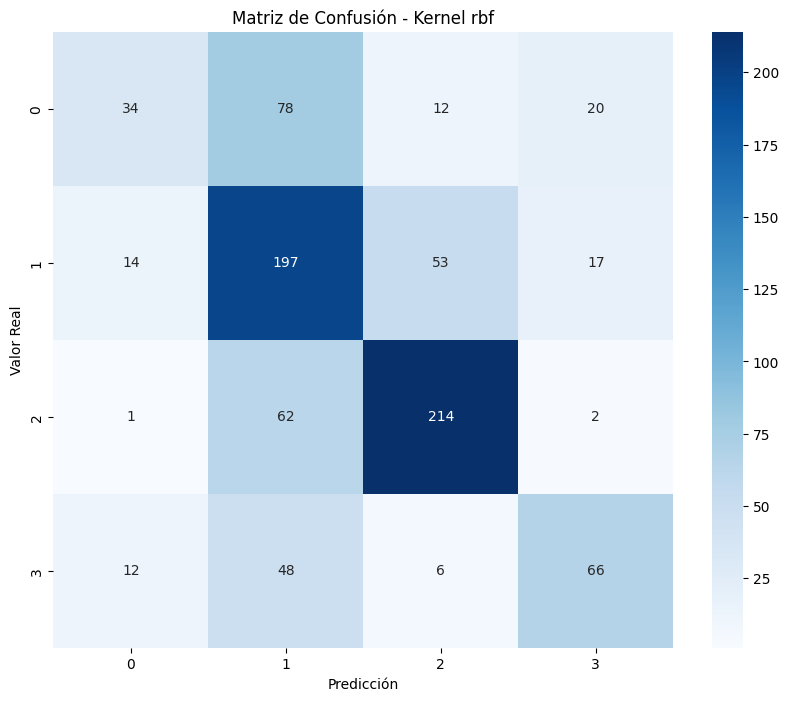


Entrenando SVM con kernel poly...

Resultados para kernel poly:
Accuracy en test: 0.5694

Resultados de validación cruzada (3-fold):
Accuracy: 0.5501 (+/- 0.0400)
Precision: 0.6133 (+/- 0.0453)
Recall: 0.4717 (+/- 0.0422)
F1-score: 0.4706 (+/- 0.0511)

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

      Adulto       0.46      0.11      0.18       144
Adulto Joven       0.46      0.79      0.58       281
       Joven       0.77      0.71      0.74       279
       Viejo       0.66      0.30      0.41       132

    accuracy                           0.57       836
   macro avg       0.59      0.48      0.48       836
weighted avg       0.59      0.57      0.54       836



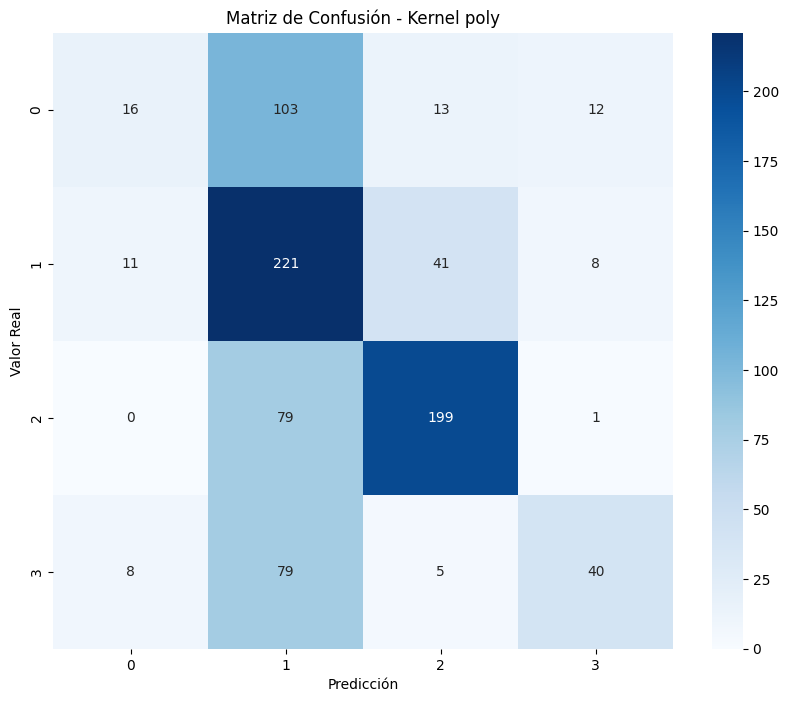


Entrenando SVM con kernel sigmoid...

Resultados para kernel sigmoid:
Accuracy en test: 0.3505

Resultados de validación cruzada (3-fold):
Accuracy: 0.3634 (+/- 0.0258)
Precision: 0.4341 (+/- 0.0440)
Recall: 0.3152 (+/- 0.0180)
F1-score: 0.2853 (+/- 0.0230)

Reporte de clasificación en conjunto de prueba:
              precision    recall  f1-score   support

      Adulto       0.16      0.31      0.21       144
Adulto Joven       0.37      0.25      0.30       281
       Joven       0.50      0.63      0.56       279
       Viejo       0.33      0.01      0.01       132

    accuracy                           0.35       836
   macro avg       0.34      0.30      0.27       836
weighted avg       0.37      0.35      0.32       836



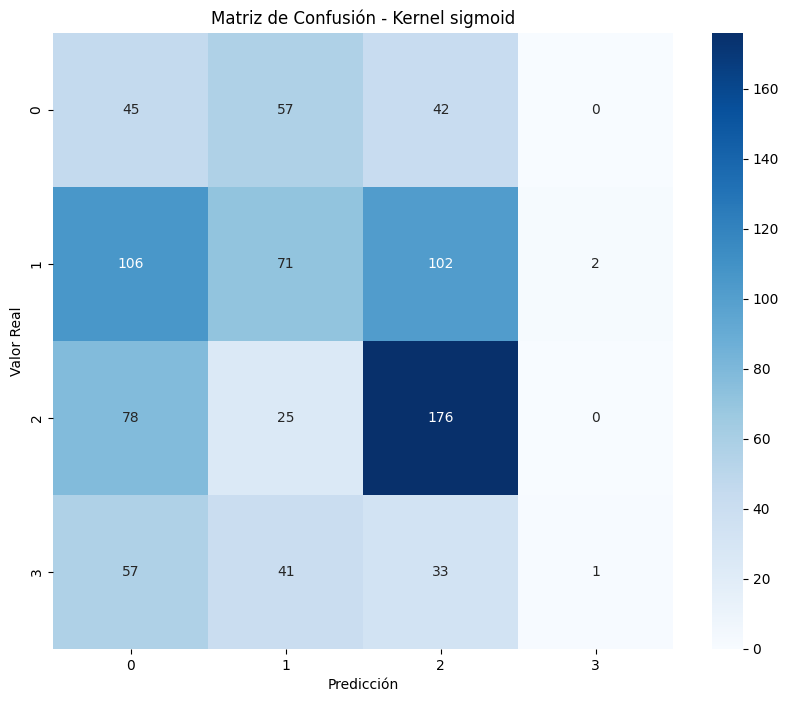

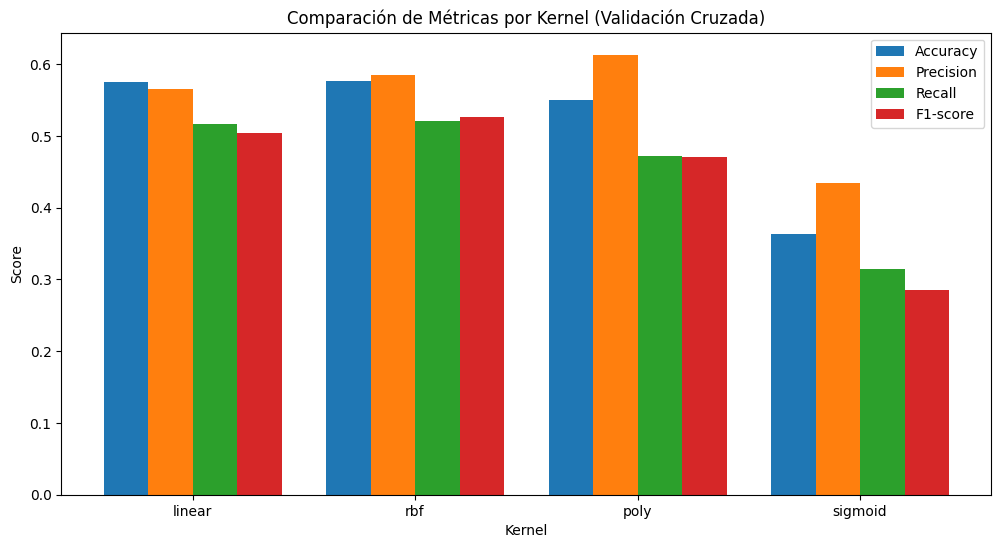


El mejor kernel es rbf con un score promedio de 0.5527

Realizando Grid Search para optimizar hiperparámetros del mejor kernel...

Mejores parámetros encontrados:
{'C': 100, 'gamma': 0.01}

Mejor accuracy con Grid Search: 0.5887


In [ ]:
# Fijar la semilla aleatoria global
np.random.seed(42)

# Cargar los datos
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight',
                'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Rings']
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data',
                   names=column_names)

# Convertir la variable categórica 'Sex' a variables dummy
data = pd.get_dummies(data, columns=['Sex'])

# Separar features y target
X = data.drop('Rings', axis=1)
y = data['Rings']

# Convertir el problema a clasificación (dividir en clases por edades)
bins = [0, 8, 10, 12, 35]
labels = ['Joven', 'Adulto Joven', 'Adulto', 'Viejo']
y = pd.cut(y, bins=bins, labels=labels)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los kernels a probar
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Diccionario para almacenar los resultados
results = {}

# Función para crear una matriz de confusión más visual
def plot_confusion_matrix(y_true, y_pred, kernel_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - Kernel {kernel_name}')
    plt.ylabel('Valor Real')
    plt.xlabel('Predicción')
    plt.show()

# Métricas a evaluar en la validación cruzada
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# Probar cada kernel
for kernel in kernels:
    print(f"\nEntrenando SVM con kernel {kernel}...")

    # Crear el modelo
    svm = SVC(kernel=kernel, random_state=42)

    # Realizar validación cruzada con 3 folds y múltiples métricas
    cv_results = cross_validate(svm, X_train_scaled, y_train,
                              cv=3,
                              scoring=scoring,
                              return_train_score=True)

    # Entrenar el modelo con todos los datos de entrenamiento para evaluación en test
    svm.fit(X_train_scaled, y_train)
    y_pred = svm.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Guardar resultados
    results[kernel] = {
        'test_accuracy': test_accuracy,
        'cv_accuracy_mean': cv_results['test_accuracy'].mean(),
        'cv_accuracy_std': cv_results['test_accuracy'].std(),
        'cv_precision_mean': cv_results['test_precision_macro'].mean(),
        'cv_precision_std': cv_results['test_precision_macro'].std(),
        'cv_recall_mean': cv_results['test_recall_macro'].mean(),
        'cv_recall_std': cv_results['test_recall_macro'].std(),
        'cv_f1_mean': cv_results['test_f1_macro'].mean(),
        'cv_f1_std': cv_results['test_f1_macro'].std()
    }

    # Imprimir resultados detallados
    print(f"\nResultados para kernel {kernel}:")
    print(f"Accuracy en test: {test_accuracy:.4f}")
    print("\nResultados de validación cruzada (3-fold):")
    print(f"Accuracy: {results[kernel]['cv_accuracy_mean']:.4f} (+/- {results[kernel]['cv_accuracy_std']*2:.4f})")
    print(f"Precision: {results[kernel]['cv_precision_mean']:.4f} (+/- {results[kernel]['cv_precision_std']*2:.4f})")
    print(f"Recall: {results[kernel]['cv_recall_mean']:.4f} (+/- {results[kernel]['cv_recall_std']*2:.4f})")
    print(f"F1-score: {results[kernel]['cv_f1_mean']:.4f} (+/- {results[kernel]['cv_f1_std']*2:.4f})")

    print("\nReporte de clasificación en conjunto de prueba:")
    print(classification_report(y_test, y_pred))

    # Visualizar matriz de confusión
    plot_confusion_matrix(y_test, y_pred, kernel)

# Visualizar comparación de resultados
plt.figure(figsize=(12, 6))
metrics = ['cv_accuracy_mean', 'cv_precision_mean', 'cv_recall_mean', 'cv_f1_mean']
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(kernels))
width = 0.2

for i, metric in enumerate(metrics):
    values = [results[k][metric] for k in kernels]
    plt.bar(x + width*i - width*1.5, values, width, label=metric_labels[i])

plt.xlabel('Kernel')
plt.ylabel('Score')
plt.title('Comparación de Métricas por Kernel (Validación Cruzada)')
plt.xticks(x, kernels)
plt.legend()
plt.show()

# Encontrar el mejor kernel basado en el promedio de todas las métricas
kernel_scores = {}
for kernel in kernels:
    avg_score = np.mean([results[kernel][metric] for metric in metrics])
    kernel_scores[kernel] = avg_score

best_kernel = max(kernel_scores.items(), key=lambda x: x[1])
print(f"\nEl mejor kernel es {best_kernel[0]} con un score promedio de {best_kernel[1]:.4f}")

# Realizar Grid Search para el mejor kernel
print("\nRealizando Grid Search para optimizar hiperparámetros del mejor kernel...")

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01]
}

grid_search = GridSearchCV(
    SVC(kernel=best_kernel[0], random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)
print(f"\nMejor accuracy con Grid Search: {grid_search.best_score_:.4f}")

El kernel rbf presenta las mejores métricas en general, seguido por linear y poly, mientras que el kernel sigmoid tiene el peor desempeño en ambas métricas. Aunque la diferencia  entre los primeros tres kernels no es extremadamente significativa, el kernel rbf se destaca como la mejor opción al ofrecer un balance entre las métricas con buenos resultados. Aunque poly tiene la mejor precisión, su recall y f1 es muy bajo. Por lo tanto, el kernel rbf parece ser el más adecuado para este conjunto de datos en términos de balance entre precisión de prueba y consistencia en la validación cruzada.

## **Referencias**

* https://www.kaggle.com/datasets/shaistashaikh/carprice-assignment

* https://www.kaggle.com/datasets/kandij/diabetes-dataset

* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

* https://archive.ics.uci.edu/dataset/1/abalone

* https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html

* https://numpy.org/doc/stable/

* https://pandas.pydata.org/docs/

* https://scikit-learn.org/1.5/modules/preprocessing.html

* https://seaborn.pydata.org/

* https://scikit-learn.org/1.5/model_selection.html

* https://scikit-learn.org/1.5/supervised_learning.html

* https://scikit-learn.org/1.5/unsupervised_learning.html

* https://www.tensorflow.org/api_docs/python/tf/keras

* https://scikit-learn.org/1.5/api/sklearn.neural_network.html

* https://scikit-learn.org/stable/modules/svm.html

* https://scikit-learn.org/1.5/modules/cross_validation.html